# Translation of GEV routines for fitting non-stationary GEV models

This code aims at translating the non-stationary GEV models from IHAMEVA toolbox into Python.

In [7]:
import pandas as pd
import numpy as np
from scipy.linalg import lu
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import numdifftools as numd

from pypalettes import load_cmap
cmap = load_cmap("Half")

class GEVnonstat:
    """ 
    The aim of this class is to select and calculate the parameters which minimize the AIC related to 
    time-dependent GEV distribution using the Maximum Likelihood method within an iterative scheme, 
    including one parameter at a time based on a perturbation criteria. 
    The process is repeated until no further improvement in the objective function is achieved. 

    The main function of this class is the AutoAdjust.

    General Inputs:
        - xt: environmental maxima data 
        - t: time when maxima occurs (yearly scale)
        - kt: Frequency parameter to measure the importance od the number of points
        - covariates: covariate dictionary where each column corresponds to the values of a covariate at the times when maxima occurs (Dictionary with the data)
        - ejemplot: Name of the corresponding data (used in plots)
        - plot: If a plot should created (by default False)
        - quanval: quantile to be plotted (by default 0.95)
        - trends: Boolean if trends should be introduced

    """

    def __init__(self, xt, t, kt=None, covariates: dict=None, ejemplo: str=None, quanval: float=0.95, trends: bool=False):
        """
        Initialize the GEVnonstat class with the required data and parameter placeholders.
        """

        # Initialize data
        if len(xt) != len(t):
            raise ValueError(f"Length of t does not match length of 'xt'.")
        
        if kt is None:
            kt = np.ones_like(xt)

        # Data dictionary
        data_dict = {'xt': xt, 't': t, 'kt': kt}
        if covariates is not None:
            for key, value in covariates.items():
                if len(value) != len(xt):
                    raise ValueError(f"Length of covariate '{key}' does not match length of 'xt' and 't'.")
                data_dict[key] = value
        self.data = pd.DataFrame(data_dict)

        # Initialize the data in different variables
        # If the input is not a numpy.array transform to numpy
        self.xt = np.array(xt)                                      # Numpy array format
        self.t = np.array(t)                                        # Numpy array format
        self.kt = np.array(kt)                                      # Numpy array format
        if covariates is not None:
            self.covariates = np.array(list(covariates.values())).T     # Numpy array format
        else:
            self.covariates = None
        self.ejemplo = ejemplo
        self.quanval = quanval                                      
        self.trends = trends                                        # False by default 
        
        

        # Initialize parameters associated to the GEV
        self.beta0 = np.empty(0)       # Location intercept
        self.beta = np.empty(0)        # Location harmonic
        self.alpha0 = np.empty(0)      # Scale intercept
        self.alpha = np.empty(0)       # Scale harmonic
        self.gamma0 = np.empty(0)      # Shape intercept
        self.gamma = np.empty(0)       # Shape harmonic
        self.betaT = np.empty(0)       # Location trend
        self.varphi = np.empty(0)      # Location covariates
        self.betaT2 = np.empty(0)      # Scale trend
        self.varphi2 = np.empty(0)     # Scale covariates

        # Initilize the number of parameters used
        self.nmu = 0            # Number of parameters of harmonic part of location
        self.npsi = 0           # Number of parameters of harmonic part of scale
        self.neps = 0           # Number of parameters of harmonic part of shape
        self.nind_loc = 0       # Number of parameters of covariates part of location
        self.ntend_loc = 0      # Number of parameters of trend part of location
        self.nind_sc = 0        # Number of parameters of covariates part of scale
        self.ntend_sc = 0       # Number of parameters of trend part of scale
        # Set by default to fit a Weibull or Frechet (not Gumbel)
        self.neps0 = 1          # 1 if shape parameter is included
    
        # Validate data
        self.validate_data()

    def validate_data(self):
        """
        Validate the input data.
        """
        required_columns = ['xt', 't', 'kt']
        for column in required_columns:
            if column not in self.data.columns:
                raise ValueError(f"Missing required column: {column}")
            if self.data[column].isnull().any():
                raise ValueError(f"Column {column} contains null values.")
            
    
    def AutoAdjust(self, maxiter = 100, plot = False):
        """
        This function automatically select and calculate the parameters which minimize the AIC related to 
        time-dependent GEV distribution using the Maximum Likelihood method within an iterative scheme, 
        including one parameter at a time based on a perturbation criteria. 
        The process is repeated until no further improvement in the objective function is achieved.

        Inputs: Previously initialized in the class initiation

        Output:
            - beta0     -> Optimal constant parameter related to location
            - beta      -> Optimal harmonic vector associated with location
            - alpha0    -> Optimal constant parameter related to scale
            - alpha     -> Optimal harmonic vector associated with scale
            - gamma0    -> Optimal constant parameter related to shape
            - gamma     -> Optimal harmonic vector associated with shape
            - betaT     -> Optimal location trend parameter
            - auxvarphi -> Optimal location covariate vector
            - betaT     -> Optimal scale trend parameter
            - auxvarphi -> Optimal scale covariate vector
            - grad      -> Gradient of the log-likelihood function with the sign changed at the optimal solution
            - hessian   -> Hessian of the log-likelihood function with the sign changed at the optimal solution
            - popt      -> vector including the optimal values for the parameters in the following order: 
                        beta0, beta, betaT, varphi, alpha0, alpha, betaT2, varphi2, gamma0, gamma
            - stdpara   -> vector including the standard deviation of the optimal values for the parameters in the following order: 
                        beta0, beta, betaT, varphi, alpha0, alpha, betaT2, varphi2, gamma0, gamma
        """

        # Validate the data again
        # self.validate_data()

        ###### Starting the iterative process

        # Set the maximum iterations
        self.maxiter = maxiter

        # Initialize the evolution vector of AIC and loglikelihood
        self.AICiter = np.zeros(maxiter)
        self.loglikeiter = np.zeros(maxiter)


        ### Step 1: Only stationary parameters (no harmonic, no covariates and no trends)
        nmu = 0         # Number of parameters of harmonic part of location
        npsi = 0        # Number of parameters of harmonic part of scale
        neps = 0        # Number of parameters of harmonic part of shape
        nind_loc = 0    # Number of parameters of covariates part of location
        ntend_loc = 0   # Number of parameters of trend part of location
        nind_sc = 0     # Number of parameters of covariates part of scale
        ntend_sc = 0    # Number of parameters of trend part of scale

        ######### HARMONIC Iterative process
        print("Starting the Harmonic iterative process")
        for iter in range(maxiter):
            ### Step 2: Obtaining MLE for the selected parameters
            beta0, beta, alpha0, alpha, gamma0, gamma, betaT, varphi, betaT2, varphi2, loglikeobj, grad, hessian, _ = self._optimize_parameters(nmu, npsi, neps)

            # Step 4.1: 
            # Check the corresponded model is Gumbel by checking the value of the gamma0
            self.neps0 = 1
            if gamma0 is None:
                self.neps0 = 0
            elif np.abs(gamma0) <= 1e-8: # Set the tolerance of being 0
                self.neps0 = 0

            # Compute the AIC
            self.loglikeiter[iter] = -loglikeobj
            self.AICiter[iter] = self._AIC(-loglikeobj, 2 + self.neps0 + 2*nmu + 2*npsi + 2*neps + nind_loc + ntend_loc + nind_sc + ntend_sc)

            ### Step 4: Calculate the sensitivities of the optimal log-likelihood objective function with respect to possible additional harmonics 
            # for the location, scale and shape parameters. Note that the new parameter values are set to zero since derivatives do not depend on them
            if beta is None:
                beta_aux = np.array([0,0])
            else:
                beta_aux = np.concatenate((beta, [0, 0]))
            if alpha is None:
                alpha_aux = np.array([0,0])
            else:
                alpha_aux = np.concatenate((alpha, [0, 0]))
            if gamma is None:
                gamma_aux = np.array([0,0])
            else:
                gamma_aux = np.concatenate((gamma, [0, 0]))
            auxf, auxJx, auxHxx = self._loglikelihood(beta0,beta_aux,alpha0,alpha_aux,gamma0,gamma_aux,None,None,None,None,None,None)


            # Inverse of the Information Matrix (auxHxx) 
            auxI0 = np.linalg.inv(-auxHxx)

            # Updating the best model
            if iter > 0:
                # TODO: Implement another criterias (Proflike)
                if self.AICiter[iter] < self.AICiter[iter-1]:
                    modelant = np.array([nmu, npsi, neps])

            else:
                modelant = np.array([nmu, npsi, neps])

            ### Step 5: Compute the maximum perturbation
            pos = 1
            maximumval = abs(auxJx[2*nmu:2*nmu+2].T @ auxI0[2*nmu:2*nmu+2, 2*nmu:2*nmu+2] @ auxJx[2*nmu:2*nmu+2])
            auxmax = abs(auxJx[2 + 2*nmu + ntend_loc + nind_loc + 2*npsi + 2:2 + 2*nmu + ntend_loc + nind_loc + 2*npsi + 2+2].T @ auxI0[2 + 2*nmu + ntend_loc + nind_loc + 2*npsi + 2:2 + 2*nmu + ntend_loc + nind_loc + 2*npsi + 2+2, 2 + 2*nmu + ntend_loc + nind_loc + 2*npsi + 2:2 + 2*nmu + ntend_loc + nind_loc + 2*npsi + 2+2] @ auxJx[2 + 2*nmu + ntend_loc + nind_loc + 2*npsi + 2:2 + 2*nmu + ntend_loc + nind_loc + 2*npsi + 2+2])

            if auxmax > maximumval:
                maximumval = auxmax
                pos = 2
            
            auxmax = abs(auxJx[2 + self.neps0 + 2*nmu + ntend_loc + nind_loc + ntend_sc + nind_sc + 2*npsi + 2*neps + 4 : 2 + self.neps0 + 2*nmu + ntend_loc + nind_loc + ntend_sc + nind_sc + 2*npsi + 2*neps + 4+2].T @ auxI0[2 + self.neps0 + 2*nmu + ntend_loc + nind_loc + ntend_sc + nind_sc + 2*npsi + 2*neps + 4 : 2 + self.neps0 + 2*nmu + ntend_loc + nind_loc + ntend_sc + nind_sc + 2*npsi + 2*neps + 4+2, 2 + self.neps0 + 2*nmu + ntend_loc + nind_loc + ntend_sc + nind_sc + 2*npsi + 2*neps + 4 : 2 + self.neps0 + 2*nmu + ntend_loc + nind_loc + ntend_sc + nind_sc + 2*npsi + 2*neps + 4+2] @ auxJx[2 + self.neps0 + 2*nmu + ntend_loc + nind_loc + ntend_sc + nind_sc + 2*npsi + 2*neps + 4 : 2 + self.neps0 + 2*nmu + ntend_loc + nind_loc + ntend_sc + nind_sc + 2*npsi + 2*neps + 4+2])
            if auxmax>maximumval:
                maximumval=auxmax
                pos = 3

            # If maximum perturbation corresponds to location, include a new harmonic
            if pos == 1:
                nmu += 1
            # If maximum perturbation corresponds to scale, include a new harmonic
            if pos == 2:
                npsi += 1
            # If maximum perturbation corresponds to shape, include a new harmonic
            if pos == 3:
                neps += 1
            

            # Model update and convergence criterion Step 5 to Step 8
            if iter == 0 and pos == 3:
                break
            
            
            if iter > 0:
                if self.AICiter[iter] >= self.AICiter[iter-1]:
                    model = modelant
                    self.AICini = self.AICiter[iter-1]
                    loglikeobjITini = self.loglikeiter[iter-1]
                    break
                else:
                    model = np.array([nmu, npsi, neps])

        self.niter_harm = iter
        self.nit = iter
        print("End of the Harmonic iterative process")
        
        ######### End of the Harmonic iterative process       
        # Obtaining the MLE for the best model
        nmu = model[0]
        npsi = model[1]
        neps = model[2]

        # CHECKING THE SHAPE PARAMETER
        self.neps0 = 0 # Force the elimination of the constant shape parameter (gamma0)
        beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,popt = self._optimize_parameters(nmu,npsi,neps)

        self.AICiter[self.niter_harm + 1] = self._AIC(-loglikeobj, 2+self.neps0+2*nmu+2*npsi+2*neps+ntend_loc+nind_loc+ntend_sc+nind_sc)
        self.loglikeiter[self.niter_harm + 1] = -loglikeobj

        if self.AICini < self.AICiter[self.niter_harm + 1]:
            # The constant shape parameter (gamma0) is significative
            self.neps0 = 1
            beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,popt = self._optimize_parameters(nmu,npsi,neps)
        
        print("Harmonic AIC:", self.AICini, "\n")

        self.neps0_aux = self.neps0
        self.beta0 = beta0
        self.beta = beta
        self.alpha0 = alpha0
        self.alpha = alpha
        self.gamma0 = gamma0
        self.gamma = gamma
        self.betaT = betaT
        self.betaT2 = betaT2
        self.varphi = varphi
        self.varphi2 = varphi2
        self.nmu = nmu
        self.npsi = npsi
        self.neps = neps
        self.popt = popt
        
        ######### COVARIATES Iterative process   
        if self.covariates is not None:
            print("Starting the Covariates iterative process")
            nd, nind = self.covariates.shape

            # Auxiliar variables related to location parameter
            auxcovariates_loc = np.empty((0,0))
            list_loc = np.empty(0).astype(int)
            auxnind_loc = nind
            # Auxiliar variabes related to scale parameter
            auxcovariates_sc = np.empty((0,0))
            list_sc = np.empty(0).astype(int)
            auxnind_sc = nind
            nind_loc = 0
            nind_sc = 0
            varphi = np.empty(0)
            varphi2 = np.empty(0)

            aux_neps0 = np.zeros(2*auxnind_loc+1)
            ### Starting Covariates iterative process
            for i in range(self.niter_harm +1, self.niter_harm+2*auxnind_loc+1):
                auxvarphi_loc = np.zeros(auxnind_loc)
                if len(list_loc) > 0:
                    auxvarphi_loc[list_loc] = varphi
                auxvarphi_sc = np.zeros(auxnind_sc)
                if len(list_sc) > 0:
                    auxvarphi_sc[list_sc] = varphi2

                ### Step 9: Calculate the sensitivities of the optimal log-likelihood objective function with respect to possible 
                # additional covariates for the location and  scale parameters
                auxf, auxJx, auxHxx = self._loglikelihood(beta0,beta,alpha0,alpha,gamma0,gamma,betaT,auxvarphi_loc,betaT2,auxvarphi_sc,self.covariates,self.covariates)

                # Step 10: Include in the parameter vector the corresponding covariate
                auxI0 = -auxHxx
                values1 = np.abs(auxJx[2 + 2*nmu + ntend_loc -1: 1 + 2*nmu + ntend_loc + auxnind_loc]**2 / np.diag(auxI0[2 + 2*nmu + ntend_loc -1: 1 + 2*nmu + ntend_loc + auxnind_loc, 2 + 2*nmu + ntend_loc -1: 1 + 2*nmu + ntend_loc + auxnind_loc]))
                maximo_loc, pos_loc = np.max(values1), np.argmax(values1)

                values2 = np.abs(auxJx[2 + 2*nmu + ntend_loc + auxnind_loc + 2*npsi : 2 + 2*nmu + ntend_loc + auxnind_loc + 2*npsi + auxnind_sc]**2 / np.diag(auxI0[2 + 2*nmu + ntend_loc + auxnind_loc + 2*npsi : 2 + 2*nmu + ntend_loc + auxnind_loc + 2*npsi + auxnind_sc, 2 + 2*nmu + ntend_loc + auxnind_loc + 2*npsi : 2 + 2*nmu + ntend_loc + auxnind_loc + 2*npsi + auxnind_sc]))
                maximo_sc, pos_sc = np.max(values2), np.argmax(values2)
                
                if varphi is not None:
                    varphiini_loc = varphi
                else:
                    varphiini_loc = []
                if varphi2 is not None:
                    varphiini_sc = varphi2
                else:
                    varphiini_sc = []
                
                #varphiini_loc = varphi
                #varphiini_sc = varphi2

                if maximo_loc > maximo_sc:
                    #varphiini_loc = np.append(auxvarphi_loc[list_loc], [0])
                    varphiini_loc = np.append(varphiini_loc, [0])
                    list_loc = np.append(list_loc, [int(pos_loc)]).astype(int)
                    nind_loc += 1
                else:
                    #varphiini_sc = np.append(auxvarphi_sc[list_sc], [0])
                    varphiini_sc = np.append(varphiini_sc, [0])
                    list_sc = np.append(list_sc, [int(pos_sc)]).astype(int)
                    nind_sc += 1

                if list_loc.size > 0:
                    auxcovariates_loc = self.covariates[:, list_loc]
                if list_sc.size > 0:
                    auxcovariates_sc = self.covariates[:, list_sc]
                if varphiini_loc is None:
                    varphiini_loc = []
                if varphiini_sc is None:
                    varphiini_sc = []
                
                

                # Step 11: Obtain the maximum-likelihood estimators for the selected parameters and 
                # calculate the Akaike Information criterion objective function AIC
                
                pini = np.concatenate([popt[0:1 + 2 * nmu], varphiini_loc, popt[1 + 2 * nmu : 2 + 2 * nmu + 2 * npsi], varphiini_sc, np.zeros(self.neps0), np.zeros(2 * neps)])
                beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,_ = self._optimize_parameters(nmu,npsi,neps,betaT,auxcovariates_loc,np.zeros(nind_loc),betaT2,auxcovariates_sc,np.zeros(nind_sc),pini)
                
                # Check if the model is Gumbel
                # self.neps0 = 1
                aux_neps0[i-self.niter_harm-1] = 1
                if gamma0 is None:
                    aux_neps0[i-self.niter_harm-1] = 0
                elif np.abs(gamma0) <= 1e-8: # Set the tolerance of being 0
                    aux_neps0[i-self.niter_harm-1] = 0

                self.AICiter[i] = self._AIC(-loglikeobj, 2+aux_neps0[i-self.niter_harm-1]+2*nmu+2*npsi+2*neps+ntend_loc+nind_loc+ntend_sc+nind_sc)
                self.loglikeiter[i] = -loglikeobj
                
                if self.AICiter[i] < self.AICini:
                    self.AICini = self.AICiter[i]

                    # Update results if the AIC obtained is less than the previous
                    self.neps0 = int(aux_neps0[i-self.niter_harm-1])
                    self.beta0 = beta0
                    self.beta = beta
                    self.alpha0 = alpha0
                    self.alpha = alpha
                    self.gamma0 = gamma0
                    self.gamma = gamma
                    self.betaT = betaT
                    self.betaT2 = betaT2
                    self.varphi = varphi
                    self.varphi2 = varphi2
                    self.list_loc = list_loc
                    self.list_sc = list_sc
                    self.nmu = nmu
                    self.npsi = npsi
                    self.neps = neps
                    self.popt = popt
                else:
                    if maximo_loc > maximo_sc:
                        list_loc = list_loc[:-1]
                        varphi = varphi[:-1]
                        nind_loc -= 1 
                    else:
                        list_sc = list_sc[:-1]
                        varphi2 = varphi2[:-1]
                        nind_sc -= 1
                    
                    self.niter_cov = i - self.niter_harm
                    self.nit = i


                self.list_loc = list_loc
                self.list_sc = list_sc

            print("End of the Covariates iterative process")
            print("Covariates AIC:", self.AICini, "\n")


        else:
            print("No covariates added \n")
            nind_loc = 0
            nind_sc = 0
            list_loc = np.empty(0).astype(int)
            list_sc = np.empty(0).astype(int)
            varphiini_loc = np.empty(0)
            varphiini_sc = np.empty(0)
            auxcovariates_loc = 0
            auxcovariates_sc = 0
            auxnind_loc = 0
            auxnind_sc = 0

            # Update the global values
            self.list_loc = list_loc
            self.list_sc = list_sc
            self.covariates = np.empty((0,0))

        if len(varphiini_loc) != nind_loc:
            varphiini_loc = varphiini_loc[:nind_loc]      
            varphi = varphiini_loc[:nind_loc] 
        if len(varphiini_sc) != nind_sc:
            varphiini_sc = varphiini_sc[:nind_sc]
            varphi2 = varphiini_sc[:nind_sc]
        
        # Update the global values
        self.varphi = varphi
        self.varphi2 = varphi2

        ##### End of the Covariates iterative process

        
        ##### Start of the Trends process
        if self.trends:
            print("Starting trends process")
            # Step 15: Location trend
            ntend_loc = 1
            betaT = np.array([0])
            pini = np.concatenate([popt[0:1+2*self.nmu], np.zeros(ntend_loc), varphiini_loc[:nind_loc], popt[2+2*self.nmu-1:2+2*self.nmu+2*self.npsi], varphiini_sc[:nind_sc], np.zeros(self.neps0), np.zeros(2*self.neps)])
            beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,_ = self._optimize_parameters(self.nmu,self.npsi,self.neps,betaT,self.covariates[:,self.list_loc],np.zeros(nind_loc),betaT2,self.covariates[:,self.list_sc],np.zeros(nind_sc),pini)

            self.AICiter[self.nit+1] = self._AIC(-loglikeobj, 2+self.neps0+2*self.nmu+2*self.npsi+2*self.neps+ntend_loc+nind_loc+ntend_sc+nind_sc)
            self.loglikeiter[self.nit+1] = -loglikeobj

            if self.AICiter[self.nit+1] > self.AICini:
                ntend_loc = 0
                betaT = np.empty(0)

                pini = np.concatenate([popt[0:1+2*self.nmu], varphiini_loc[:nind_loc], popt[2+2*self.nmu-1:2+2*self.nmu+2*self.npsi], varphiini_sc[:nind_sc], np.zeros(self.neps0), np.zeros(2*self.neps)])
                beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,_ = self._optimize_parameters(self.nmu,self.npsi,self.neps,betaT,self.covariates[:,self.list_loc],np.zeros(nind_loc),betaT2,self.covariates[:,self.list_sc],np.zeros(nind_sc),pini)
                print("Location trend parameter not significant")

            else:
                self.AICini = self.AICiter[self.nit+1]
                self.betaT = betaT
                print("Adding trend term to location parameter")
                print("Location trend AIC: ", self.AICini)
                loglikeobjITini = self.loglikeiter[self.nit+1]

            # Step 18: Scale trend
            ntend_sc = 1
            betaT2 = np.array([0])
            pini = np.concatenate([popt[0:1+2*self.nmu], np.zeros(ntend_loc), varphiini_loc[:nind_loc], popt[2+2*self.nmu-1:2+2*self.nmu+2*self.npsi], np.zeros(ntend_sc), varphiini_sc[:nind_sc], np.zeros(self.neps0), np.zeros(2*self.neps)])
            beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,_ = self._optimize_parameters(self.nmu,self.npsi,self.neps,self.betaT,self.covariates[:,self.list_loc],np.zeros(nind_loc),betaT2,self.covariates[:,self.list_sc],np.zeros(nind_sc),pini)

            self.AICiter[self.nit+2] = self._AIC(-loglikeobj, 2+self.neps0+2*self.nmu+2*self.npsi+2*self.neps+ntend_loc+nind_loc+ntend_sc+nind_sc)
            self.loglikeiter[self.nit+2] = -loglikeobj

            if self.AICiter[self.nit+2] > self.AICini:
                ntend_sc = 0
                betaT2 = np.empty(0)
                pini = np.concatenate([popt[0:1+2*self.nmu], np.zeros(ntend_loc), varphiini_loc[:nind_loc], popt[2+2*self.nmu-1:2+2*self.nmu+2*self.npsi], varphiini_sc[:nind_sc], np.zeros(self.neps0), np.zeros(2*self.neps)])
                beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,_ = self._optimize_parameters(self.nmu,self.npsi,self.neps,self.betaT,self.covariates[:,self.list_loc],np.zeros(nind_loc),betaT2,self.covariates[:,self.list_sc],np.zeros(nind_sc),pini)        
                print("Scale trend parameter not significant")

            else:
                self.AICini = self.AICiter[self.nit+2]
                self.betaT2 = betaT2
                print("Adding trend term to scale parameter")
                print("Scale trend AIC: ", self.AICini)
                loglikeobjITini = self.loglikeiter[self.nit+2]

            self.nit += 2


        else:
            beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,_ = self._optimize_parameters(self.nmu,self.npsi,self.neps,self.betaT,self.covariates[:,self.list_loc],np.zeros(nind_loc),self.betaT2,self.covariates[:,self.list_sc],np.zeros(nind_sc),np.concatenate([popt[0:1+2*self.nmu], np.zeros(ntend_loc), varphiini_loc[:nind_loc], popt[2+2*self.nmu-1:2+2*self.nmu+2*self.npsi], varphiini_sc[:nind_sc], np.zeros(self.neps0), np.zeros(2*self.neps)]))
        
        ##### End of the Trends process

        ##### Setting the final parameters values
        #NOTE: AÑADIDO POR MI
        # Checking if the result model is Gumbel

        # If the gamma0 value is too small, remove it
        ### if np.abs(gamma0) < 1e-8:
        ###     self.neps0 = 0
        ###     beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,_ = self._optimize_parameters(self.nmu,self.npsi,self.neps,self.betaT,self.covariates[:,self.list_loc],np.zeros(nind_loc),self.betaT2,self.covariates[:,self.list_sc],np.zeros(nind_sc),np.concatenate([popt[0:1+2*self.nmu], np.zeros(ntend_loc), varphiini_loc[:nind_loc], popt[2+2*self.nmu-1:2+2*self.nmu+2*self.npsi], varphiini_sc[:nind_sc], np.zeros(self.neps0), np.zeros(2*self.neps)]))
        ### # If the gamma's value is too small, remove it
        ### for i in range(self.neps):
        ###     if (np.abs(gamma[2*i]) < 1e-8) or (np.abs(gamma[2*i+1]) < 1e-8):
        ###         self.neps = self.neps - 1
### 
        ### beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,_ = self._optimize_parameters(self.nmu,self.npsi,self.neps,self.betaT,self.covariates[:,self.list_loc],np.zeros(nind_loc),self.betaT2,self.covariates[:,self.list_sc],np.zeros(nind_sc),np.concatenate([popt[0:1+2*self.nmu], np.zeros(ntend_loc), varphiini_loc[:nind_loc], popt[2+2*self.nmu-1:2+2*self.nmu+2*self.npsi], varphiini_sc[:nind_sc], np.zeros(self.neps0), np.zeros(2*self.neps)]))
        _, _, epst1 = self._evaluate_params(beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,self.covariates[:,self.list_loc],self.covariates[:,self.list_sc])

        if all(np.abs(epst1) < 1e-8):
            self.neps0 = 0
            self.neps = 0
            beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,loglikeobj,grad,hessian,_ = self._optimize_parameters(self.nmu,self.npsi,self.neps,self.betaT,self.covariates[:,self.list_loc],np.zeros(nind_loc),self.betaT2,self.covariates[:,self.list_sc],np.zeros(nind_sc),np.concatenate([popt[0:1+2*self.nmu], np.zeros(ntend_loc), varphiini_loc[:nind_loc], popt[1+2*self.nmu:2+2*self.nmu+2*self.npsi], varphiini_sc[:nind_sc], np.zeros(ntend_sc)]))

             



        # Set the final values for the covariates in the appropiate order
        auxvarphi_loc = np.zeros(auxnind_loc)
        auxvarphi_sc = np.zeros(auxnind_sc)
        if len(list_loc) > 0:
            auxvarphi_loc[list_loc] = varphi
        if len(list_sc) > 0:
            auxvarphi_sc[list_sc] = varphi2

        #loglike, Jx, Hxx = self._loglikelihood(beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,self.covariates[:,self.list_loc],self.covariates[:,self.list_sc])
       

        # Numerical Hessian (sign chaged)
        p = np.concatenate([np.atleast_1d(value) for value in [beta0, beta, betaT, varphi, alpha0, alpha, betaT2, varphi2, gamma0, gamma] if value is not None])   # Concatenate only if the value is not None
        numHxx = self.compute_numerical_hessian(p,2*self.nmu,2*self.npsi,2*self.neps,ntend_loc,self.covariates[:,self.list_loc],ntend_sc,self.covariates[:,self.list_sc])
        ### self.numHxx = -numHxx
        
        ##### Standard deviation for the parameters
        # Change the sign of the Hessian to obtain the Fisher information matrix
        ### PX, LX, UX = lu(numHxx)    # Imported function from scipy
### 
        ### # Inverse
        ### invI0 = np.linalg.solve(UX, np.linalg.solve(LX, PX @ np.eye(2 + self.neps0 + 2*self.nmu + 2*self.npsi + 2*self.neps + ntend_loc + nind_loc + ntend_sc + nind_sc)))
        
        invI0 = np.linalg.pinv(numHxx)
        
        ### Change the negative elements of the diagonal
        ###diag_indices = np.diag_indices_from(invI0)
        ###invI0[diag_indices] = np.where(invI0[diag_indices] < 0, 1e-8, invI0[diag_indices])[0]

        # Standard deviation
        stdpara = np.sqrt(np.diag(invI0))
        #stdpara = 0

        # Best parameter vector
        popt = [beta0, beta, betaT, auxvarphi_loc, alpha0, alpha, betaT2, auxvarphi_sc, gamma0, gamma]

        # Change the sign for loglikelihood function, Jacobian, and Hessian
        loglikeobj = -loglikeobj # loglike
        grad = -grad #Jx
        hessian = -numHxx
        
        # Store the data
        self.beta0 = beta0
        self.beta = beta
        self.alpha0 = alpha0
        self.alpha = alpha
        self.gamma0 = gamma0
        self.gamma = gamma
        self.betaT = betaT
        self.ntend_loc = ntend_loc
        self.betaT2 = betaT2
        self.ntend_sc = ntend_sc
        self.varphi = auxvarphi_loc[np.sort(self.list_loc)]
        self.nind_loc = nind_loc
        self.varphi2 = auxvarphi_sc[np.sort(self.list_sc)]
        self.nind_sc = nind_sc
        self.list_loc = np.sort(list_loc)
        self.list_sc = np.sort(list_sc)
        self.nmu = nmu
        self.npsi = npsi
        #self.neps = neps ## LO CAMBIO ARRIBA
        self.model = np.array([self.nmu, self.npsi, self.neps])
        self.popt = popt
        self.loglikelihood = loglikeobj
        self.grad = grad
        self.hessian = hessian
        self.invI0 = invI0
        self.stdpara = stdpara

        if self.ejemplo is not None and plot:
            self.plot()

        return [self.beta0,self.beta,self.alpha0,self.alpha,self.gamma0,self.gamma,self.betaT,self.varphi,self.list_loc,betaT2,self.varphi2,self.list_sc,self.loglikelihood,self.grad,self.hessian,self.popt,self.stdpara]
    

    def _AIC(self, loglik, np):
        """
        Compute the AIC for a certain loglikelihood value (loglik) and the number of parameters (np) 
        """
        return -2*(loglik) + 2*np
    


    def _optimize_parameters(self, nmu, npsi, neps, betaT=None, covariates_loc=None, varphi=None, betaT2=None, covariates_sc=None, varphi2=None, pini = None):
        """ 
        Function to calculate the parameters of the Time-Dependent GEV distribution
        using the maximum likelihood method.

        Inputs:
        - nmu, npsi, neps: Number of harmonics for location, scale, and shape
        - betaT, varphi, betaT2, varphi2: Optional trend and covariates for location and scale
        - indices, indices2: Covariates data for location and scale
        - pini: Initial parameter guesses if the following order: beta0, beta, betaT, varphi, alpha0, alpha, betaT2, varphi2, gamma0, gamma

        Outputs:
        - beta0, beta, alpha0, alpha, gamma0, gamma, betaT, varphi, betaT2, varphi2: Value of the estimated parameters
        - fval: Negative Loglikelihood value for the estimated parameter
        - grad: Gradient of the log-likelihood function with the sign changed at the optimal solution
        - hessian: Hessian of the log-likelihood function with the sign changed at the optimal solution
        - p: vector including the optimal values for the parameters in the following order: beta0, beta, betaT, varphi, alpha0, alpha, betaT2, varphi2, gamma0, gamma
        """
        # Check and set default values if necessary
        if betaT is None or betaT.size == 0:
            betaT = np.empty(0)
            ntend_loc = 0
        else:
            ntend_loc = 1
        if covariates_loc is None or covariates_loc.shape[1] == 0:
            covariates_loc = np.empty((0,0))
        if varphi is None or len(varphi) == 0:
            varphi = np.empty(0)
        if betaT2 is None or betaT2.size == 0:
            betaT2 = np.empty(0)
            ntend_sc = 0
        else:
            ntend_sc = 1
        if covariates_sc is None or covariates_sc.shape[1] == 0:
            covariates_sc = np.empty((0,0))
        if varphi2 is None or len(varphi2) == 0:
            varphi2 = np.empty(0)
        if pini is None or len(pini) == 0:
            pini = np.empty(0)
            
        # Chekc if the covariates are defined properly
        na1, nind_loc = covariates_loc.shape
        nind_varphi_loc = len(varphi)

        if nind_loc != nind_varphi_loc:
            ValueError("The number of columns in the covariate data matrix does not coincide with the number of covariate parameters (varphi)")
        
        if nind_loc >0:
            if na1 != len(self.xt) or na1 != len(self.t) or len(self.xt) != len(self.t):
                ValueError("Check the dimensions of data x, t and covariates_loc")

        na2, nind_sc = covariates_sc.shape
        nind_varphi_sc = len(varphi2)
        if nind_sc != nind_varphi_sc:
            ValueError("The number of columns in the covariate data matrix does not coincide with the number of covariate parameters (varphi2)")
        
        if nind_sc >0:
            if na2 != len(self.xt) or na2 != len(self.t) or len(self.xt) != len(self.t):
                ValueError("Check the dimensions of data x, t and covariates_sc")

        # Calculating the number of total parameters to be estimated
        nmu = 2*nmu                                                         # Related to location
        npsi = 2*npsi                                                       # Related to scale
        neps = 2*neps                                                       # Related to shape
        # The number of covariates related to location and scale is storaged in nind_loc and nind_sc, respectively

        # Initial bounds and possible initial values for the constant parameters related to location, scale and shape
        length_p = 2 + self.neps0 + nmu + npsi + neps + ntend_loc + nind_loc + ntend_sc + nind_sc
        p = np.zeros(length_p)
        
        # Initial beta0 parameter with the mean of the data
        p[0] = np.mean(self.xt)
        # Initial alpha0 parameter with the sd of the data
        p[1+nmu+ntend_loc+nind_loc] = np.log(np.std(self.xt))
        # Initial gamma0 parameter
        if self.neps0 == 1:
            p[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc] = 0.01
        # Initial gamma parameters
        if neps > 0:
            p[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc: 2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+neps] = 0.01
        
        # Bounds on variables
        # Initially all parameters are unbounded
        lb = -np.inf * np.ones_like(p)
        ub = np.inf * np.ones_like(p)
            

        # Initial bounds for the parameters related to the shape, gamma0 and gamma 
        if self.neps0 == 1:
            lb[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc] = -0.2
            ub[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc] = 0.2

        if neps > 0:
            lb[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc: 2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+neps] = -0.15
            ub[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc: 2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+neps] = 0.15

        # If an inital value for the parameters vector is provided, it is used
        if pini is not None and len(pini) > 0:
            p = np.minimum(pini, ub)
            p = np.maximum(pini, lb)
        

        # Set the bounds properly for scipy.optimize.minimize
        bounds = [(lb_i, up_i) for lb_i, up_i in zip(lb, ub)]
        result = minimize(
            fun=self._auxmin_loglikelihood,
            jac=self._auxmin_loglikelihood_grad,     # Gradient information
            x0=p,
            bounds=bounds,
            args = (nmu, npsi, neps, ntend_loc, covariates_loc, ntend_sc, covariates_sc),
            #hess="2-point",  # Hessian information, if applicable
            options={"ftol": 1e-12}, # Options 
            method = "TNC" # L-BFGS-B, TNC, SLSQP, trust-constr
        )

        p = result.x
        fval = result.fun
        exitflag = result.success
        output = result.message
        grad = result.jac
        hessian = result.hess_inv if 'hess_inv' in result else None  # 'hess_inv' is only available if 'hess' is provided

        # Check if any of the bounds related to shape parameters become active, if active increase or decrease the bound and call the optimization routine again
        # TODO: NECESARIO??? NO CAMBIA LA SOLUCION Remove 3 #
        auxlb = []
        auxub = []
        for i in range(len(p)):
            if lb[i] >= p[i]:
                lb[i] = lb[i] - 0.05
                auxlb.append(i)
            if ub[i] <= p[i]:
                ub[i] = ub[i] + 0.05
                auxub.append(i)

        it = 0
        while (len(auxlb) > 0 or len(auxub) > 0) and it < 10:
            it += 1
            result = minimize(
                fun=self._auxmin_loglikelihood,
                jac=self._auxmin_loglikelihood_grad,     # Gradient information
                x0=p,
                bounds=bounds,
                args = (nmu, npsi, neps, ntend_loc, covariates_loc, ntend_sc, covariates_sc),
                #hess="2-point",  # Hessian information, if applicable
                options={"ftol": 1e-12}, # Options 
                method = "TNC" 
            )
            p = result.x
            fval = result.fun
            exitflag = result.success
            output = result.message
            grad = result.jac
            hessian = result.hess_inv if 'hess_inv' in result else None  # 'hess_inv' is only available if 'hess' is provided
            auxlb = []
            auxub = []
            for i in range(len(p)):
                if lb[i] >= p[i]:
                    lb[i] = lb[i] - 0.05
                    auxlb.append(i)
                if ub[i] <= p[i]:
                    ub[i] = ub[i] + 0.05
                    auxub.append(i)



        # Once the optimal solution is obtained, redistribute the solution storaged in p
        # Location parameter
        beta0 = p[0]
        if nmu > 0:
            beta = p[1:1+nmu]
        else:
            beta = None
        if ntend_loc > 0:
            betaT = p[1+nmu]
        else:
            betaT = None
        if nind_loc > 0:
            varphi = p[1+nmu+ntend_loc:1+nmu+ntend_loc+nind_loc]
        else:
            varphi = None

        # Scale parameter
        alpha0 = p[1+nmu+ntend_loc+nind_loc]
        if npsi > 0:
            alpha = p[2+nmu+ntend_loc+nind_loc:2+nmu+ntend_loc+nind_loc+npsi]
        else:
            alpha = None
        if ntend_sc > 0:
            betaT2 = p[2+nmu+ntend_loc+nind_loc+npsi]
        else:
            betaT2 = None
        if nind_sc > 0:
            varphi2 = p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc:2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc]
        else:
            varphi2 = None

        # Shape parameter
        if self.neps0 == 1:
            gamma0 = p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc]
        else:
            gamma0 = None
        if neps > 0:
            gamma = p[2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc: 2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc+neps]
        else:
            gamma = None

        
        return beta0, beta, alpha0, alpha, gamma0, gamma, betaT, varphi, betaT2, varphi2, fval, grad, hessian, p




    def _auxmin_loglikelihood(self, p, nmu, npsi, neps, ntend_loc=None, covariates_loc=None, ntend_sc=None, covariates_sc=None):
        """
        Function used for minimizing in the 'self._optimize_parameters' where the Negative loglikelihood of the GEV will be minimized
        """
        # Cheking the inputs
        if ntend_loc is None:
            ntend_loc=0
        if covariates_loc is None:
            covariates_loc = np.empty((0,0))
        if ntend_sc is None:
            ntend_sc = 0
        if covariates_sc is None:
            covariates_sc = np.empty((0,0))

        #Check consistency of the data 
        na1, nind_loc = covariates_loc.shape
        if nind_loc > 0 and na1 > 0:
            if na1 != len(self.xt) or na1 != len(self.t) or len(self.xt) != len(self.t):
                ValueError("Check data x, t, indices: funcion aux loglikelihood")
                
        na2, nind_sc = covariates_sc.shape
        if nind_sc > 0 and na2 > 0:
            if na2 != len(self.xt) or na2 != len(self.t) or len(self.xt) != len(self.t):
                ValueError("Check data x, t, indices: funcion aux loglikelihood")

        # Evaluate the location parameter at each time t as a function of the actual values of the parameters given by p
        if ntend_loc == 0 and nind_loc == 0:
            mut1 = self._parametro(p[0], p[1:1+nmu]) # beta0, beta
        elif ntend_loc == 0 and nind_loc != 0:
            mut1 = self._parametro(p[0], p[1:1+nmu], None, covariates_loc, p[1+nmu+ntend_loc:1+nmu+ntend_loc+nind_loc]) # beta0, beta, varphi
        elif ntend_loc != 0 and nind_loc == 0:
            mut1 = self._parametro(p[0], p[1:1+nmu], np.array(p[1+nmu])) # beta0, beta, betaT
        else:
            mut1 = self._parametro(p[0], p[1:1+nmu], np.array(p[1+nmu]), covariates_loc,p[1+nmu+ntend_loc:1+nmu+ntend_loc+nind_loc]) # beta0, beta, betaT, varphi

        # Evaluate the scale parameter at each time t as a function of the actual values of the parameters given by p 
        if ntend_sc == 0 and nind_sc == 0:
            psit1 = np.exp(self._parametro(p[1+nmu+ntend_loc+nind_loc], p[2+nmu+ntend_loc+nind_loc:2+nmu+ntend_loc+nind_loc+npsi])) # alpha0, alpha
        elif ntend_sc == 0 and nind_sc != 0:
            psit1 = np.exp(self._parametro(p[1+nmu+ntend_loc+nind_loc], p[2+nmu+ntend_loc+nind_loc:2+nmu+ntend_loc+nind_loc+npsi], None, covariates_sc, p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc:2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc])) # alpha0, alpha, varphi2
        elif ntend_sc != 0 and nind_sc == 0:
            psit1 = np.exp(self._parametro(p[1+nmu+ntend_loc+nind_loc], p[2+nmu+ntend_loc+nind_loc:2+nmu+ntend_loc+nind_loc+npsi], np.array(p[2+nmu+ntend_loc+nind_loc+npsi]))) # alpha0, alpha, betaT2
        else:
            psit1 = np.exp(self._parametro(p[1+nmu+ntend_loc+nind_loc], p[2+nmu+ntend_loc+nind_loc:2+nmu+ntend_loc+nind_loc+npsi], np.array(p[2+nmu+ntend_loc+nind_loc+npsi]), covariates_sc, p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc:2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc])) # alpha0, alpha, betaT2, varphi2

        # Evaluate the shape parameter at each time t as a function of the actual values of the parameters given by p
        if neps == 0:
            if self.neps0 == 1:
                # epst = p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc]*np.ones_like(mut1)
                epst = self._parametro(p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc], None) # gamma0
            else:
                epst = 0*mut1 # Gumbel
        else:
            if self.neps0 == 1:
                epst = self._parametro(p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc], p[2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc: 2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc+neps]) # gamma0, gamma
            else:
                epst = self._parametro(0, p[2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc: 2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc+neps]) # gamma

        # The values whose shape parameter is almost 0 correspond to the Gumbel distribution
        posG = list(np.where(np.abs(epst) <= 1e-8)[0])
        # The remaining values correspond to Weibull or Frechet
        pos = list(np.where(np.abs(epst) > 1e-8)[0])

        # The corresponding Gumbel values are set to 1 to avoid numerical problems, note that in this case, the Gumbel expressions are used
        epst[posG] = 1

        # Modify the parameters to include the length of the data
        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos]+psit1[pos]*(self.kt[pos]**epst[pos]-1)/epst[pos]
        psit[pos] = psit1[pos]*self.kt[pos]**epst[pos]
        # Modify the parameters to include the length of the data in Gumbel
        mut[posG] = mut[posG] + psit[posG]*np.log(self.kt[posG])

        # Evaluate auxiliarly variables
        xn = (self.xt-mut)/psit
        z = 1+epst*xn
        
        # Since z-values must be greater than 0 in order to avoid numerical problems, their values are set to be greater than 1e-8
        z = np.maximum(1e-8, z)
        zn = z**(-1/epst)

        # Evaluate the loglikelihood function with the sign changed, not that the general and Gumbel expressions are used
        f = np.sum(-np.log(self.kt[pos]) + np.log(psit[pos]) + (1+1/epst[pos])*np.log(z[pos])+self.kt[pos]*zn[pos]) + \
            np.sum(-np.log(self.kt[posG]) + np.log(psit[posG]) + xn[posG] + self.kt[posG]*np.exp(-xn[posG]))
        
        return f
    
    def _auxmin_loglikelihood_grad(self, p, nmu, npsi, neps, ntend_loc=None, covariates_loc=None, ntend_sc=None, covariates_sc=None):
        """
        Function used for minimizing in the 'self._optimize_parameters' where the Negative loglikelihood of the GEV will be minimized
        """
        # Cheking the inputs
        if ntend_loc is None:
            ntend_loc=0
        if covariates_loc is None:
            covariates_loc = np.empty((0,0))
        if ntend_sc is None:
            ntend_sc = 0
        if covariates_sc is None:
            covariates_sc = np.empty((0,0))

        #Check consistency of the data 
        na1, nind_loc = covariates_loc.shape
        if nind_loc > 0 and na1 > 0:
            if na1 != len(self.xt) or na1 != len(self.t) or len(self.xt) != len(self.t):
                ValueError("Check data x, t, indices: funcion aux loglikelihood")
                
        na2, nind_sc = covariates_sc.shape
        if nind_sc > 0 and na2 > 0:
            if na2 != len(self.xt) or na2 != len(self.t) or len(self.xt) != len(self.t):
                ValueError("Check data x, t, indices: funcion aux loglikelihood")

        # Evaluate the location parameter at each time t as a function of the actual values of the parameters given by p
        if ntend_loc == 0 and nind_loc == 0:
            mut1 = self._parametro(p[0], p[1:1+nmu]) # beta0, beta
        elif ntend_loc == 0 and nind_loc != 0:
            mut1 = self._parametro(p[0], p[1:1+nmu], None, covariates_loc, p[1+nmu+ntend_loc:1+nmu+ntend_loc+nind_loc]) # beta0, beta, varphi
        elif ntend_loc != 0 and nind_loc == 0:
            mut1 = self._parametro(p[0], p[1:1+nmu], p[1+nmu]) # beta0, beta, betaT
        else:
            mut1 = self._parametro(p[0], p[1:1+nmu], p[1+nmu], covariates_loc,p[1+nmu+ntend_loc:1+nmu+ntend_loc+nind_loc]) # beta0, beta, betaT2, varphi

        # Evaluate the scale parameter at each time t as a function of the actual values of the parameters given by p 
        if ntend_sc == 0 and nind_sc == 0:
            psit1 = np.exp(self._parametro(p[1+nmu+ntend_loc+nind_loc], p[2+nmu+ntend_loc+nind_loc:2+nmu+ntend_loc+nind_loc+npsi])) # alpha0, alpha
        elif ntend_sc == 0 and nind_sc != 0:
            psit1 = np.exp(self._parametro(p[1+nmu+ntend_loc+nind_loc], p[2+nmu+ntend_loc+nind_loc:2+nmu+ntend_loc+nind_loc+npsi], None, covariates_sc, p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc:2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc])) # alpha0, alpha, varphi2
        elif ntend_sc != 0 and nind_sc == 0:
            psit1 = np.exp(self._parametro(p[1+nmu+ntend_loc+nind_loc], p[2+nmu+ntend_loc+nind_loc:2+nmu+ntend_loc+nind_loc+npsi], p[2+nmu+ntend_loc+nind_loc+npsi])) # alpha0, alpha, betaT2
        else:
            psit1 = np.exp(self._parametro(p[1+nmu+ntend_loc+nind_loc], p[2+nmu+ntend_loc+nind_loc:2+nmu+ntend_loc+nind_loc+npsi], p[2+nmu+ntend_loc+nind_loc+npsi], covariates_sc, p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc:2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc])) # alpha0, alpha, betaT2, varphi2

        # Evaluate the shape parameter at each time t as a function of the actual values of the parameters given by p
        if neps == 0:
            if self.neps0 == 1:
                epst = self._parametro(p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc], None) # gamma0
            else:
                epst = 0*mut1 # Gumbel
        else:
            if self.neps0 == 1:
                epst = self._parametro(p[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc], p[2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc: 2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc+neps]) # gamma0, gamma
            else:
                epst = self._parametro(0, p[2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc: 2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc+neps]) # gamma

        # The values whose shape parameter is almost 0 correspond to the Gumbel distribution
        posG = np.where(np.abs(epst) <= 1e-8)[0]
        # The remaining values correspond to Weibull or Frechet
        pos = np.where(np.abs(epst) > 1e-8)[0]

        # The corresponding Gumbel values are set to 1 to avoid numerical problems, note that in this case, the Gumbel expressions are used
        epst[posG] = 1

        # Modify the parameters to include the length of the data
        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos]+psit1[pos]*(self.kt[pos]**epst[pos]-1)/epst[pos]
        psit[pos] = psit1[pos]*self.kt[pos]**epst[pos]
        # Modify the parameters to include the length of the data in Gumbel
        mut[posG] = mut[posG] + psit[posG]*np.log(self.kt[posG])

        # Evaluate auxiliarly variables
        xn = (self.xt-mut)/psit
        z = 1+epst*xn
        
        # Since z-values must be greater than 0 in order to avoid numerical problems, their values are set to be greater than 1e-8
        z = np.maximum(1e-8, z)
        zn = z**(-1/epst)

        # Evaluate the loglikelihood function with the sign changed, not that the general and Gumbel expressions are used
        f = np.sum(-np.log(self.kt[pos]) + np.log(psit[pos]) + (1+1/epst[pos])*np.log(z[pos])+self.kt[pos]*zn[pos]) + \
            np.sum(-np.log(self.kt[posG]) +np.log(psit[posG]) + xn[posG] + self.kt[posG]*np.exp(-xn[posG]))
        

        ### Gradient of the loglikelihood
        # Derivatives given by equations (A.1)-(A.3) in the paper
        Dmut = (1+epst-self.kt*zn) / (psit*z)
        Dpsit = -(1-xn*(1-self.kt*zn)) / (psit*z)
        Depst = zn * (xn*(self.kt-(1+epst)/zn)+z*(-self.kt+1/zn)*np.log(z)/epst) / (epst*z)

        # Gumbel derivatives given by equations (A.4)-(A.5) in the paper
        Dmut[posG] = (1-self.kt[posG]*np.exp(-xn[posG])) / psit[posG]
        Dpsit[posG] = (xn[posG]-1-self.kt[posG]*xn[posG]*np.exp(-xn[posG])) / (psit[posG])
        Depst[posG] = 0


        ## New Derivatives
        Dmutastmut = np.ones_like(self.kt)
        Dmutastpsit = (-1 + self.kt ** epst) / epst
        Dmutastepst = psit1 * (1 + (self.kt ** epst) * (epst * np.log(self.kt) - 1)) / (epst ** 2)

        Dpsitastpsit = self.kt ** epst
        Dpsitastepst = np.log(self.kt) * psit1 * (self.kt ** epst)

        Dmutastpsit[posG] = np.log(self.kt[posG])
        Dmutastepst[posG] = 0

        Dpsitastpsit[posG] = 1
        Dpsitastepst[posG] = 0

        # Set the Jacobian to zero
        Jx = np.zeros(2 + self.neps0 + nmu + npsi + neps + ntend_loc + nind_loc + ntend_sc + nind_sc)
        # Jacobian elements related to the location parameters beta0 and beta, equation (A.6) in the paper
        Jx[0] = np.dot(Dmut,Dmutastmut)

        # If location harmonics are included
        if nmu > 0:
            for i in range(nmu):
                aux = 0
                for k in range(len(self.t)):
                    aux += Dmut[k]*Dmutastmut[k]*self._Dparam(self.t[k], i+1)
                Jx[i+1] = aux
        
        # Jacobian elements related to the location parameters betaT, varphi (equation A.9)
        if ntend_loc > 0:
            Jx[1+nmu] = np.sum(Dmut*self.t*Dmutastmut)  # betaT
        if nind_loc > 0:
            for i in range(nind_loc):
                Jx[1+nmu+ntend_loc+i] = np.sum(Dmut*covariates_loc[:,i]*Dmutastmut) # varphi_i
        
        # Jacobian elements related to the scale parameters alpha0, alpha (equation A.7)
        Jx[1+nmu+ntend_loc+nind_loc] = np.sum(psit1*(Dpsit*Dpsitastpsit+Dmut*Dmutastpsit))  # alpha0
        # If scale harmonic are included
        if npsi > 0:
            for i in range(npsi):
                aux = 0
                for k in range(len(self.t)):
                    aux += self._Dparam(self.t[k], i+1)*psit1[k]*(Dpsit[k]*Dpsitastpsit[k]+Dmut[k]*Dmutastpsit[k])
                Jx[2+nmu+ntend_loc+nind_loc+i] = aux    # alpha
        # Jacobian elements related to the scale parameters betaT2 and varphi (equation A.10)
        if ntend_sc > 0:
            Jx[2+nmu+ntend_loc+nind_loc+npsi] = np.sum((Dpsit*Dpsitastpsit+Dmut*Dmutastpsit)*self.t*psit1)  # betaT2
        if nind_sc > 0:
            for i in range(nind_sc):
                Jx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+i] = np.sum((Dpsit*Dpsitastpsit+Dmut*Dmutastpsit)*covariates_sc[:,i]*psit1) # varphi2

        # Jacobian elements related to the shape parameters gamma0 and gamma (equation A.10)
        if self.neps0 == 1:
            Jx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc] = np.sum(Depst+Dpsit*Dpsitastepst+Dmut*Dmutastepst)
        # If shape harmonics are included
        if neps > 0:
            for i in range(neps):
                aux = 0
                for k in range(len(self.t)):
                    aux += (Depst[k]+Dpsit[k]*Dpsitastepst[k]+Dmut[k]*Dmutastepst[k])*self._Dparam(self.t[k],i+1)
                Jx[2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc + i] = aux
        
        # Change the Jacobian sign since the numerical problem is a minimization problem
        Jx = -Jx
        
        return Jx
    
    def compute_numerical_hessian(self, p, nmu, npsi, neps, ntend_loc=None, covariates_loc=None, ntend_sc=None, covariates_sc=None):
        """
        Compute the numerical Hessian of _auxmin_loglikelihood with respect to p using numdifftools.
        """
        
        # Wrapper function for _auxmin_loglikelihood to fix other parameters
        def func_for_hessian(x):
            return self._auxmin_loglikelihood(
                x, nmu, npsi, neps, ntend_loc, covariates_loc, ntend_sc, covariates_sc
            )

        # Use numdifftools' Hessian function
        hessian_func = numd.Hessian(func_for_hessian)
        hessian_matrix = hessian_func(p)
        
        return hessian_matrix


    def _loglikelihood(self, beta0=None,beta=None,alpha0=None,alpha=None,gamma0=None,gamma=None,betaT=None,varphi=None,betaT2=None,varphi2=None,covariates_loc=None,covariates_sc=None):
        """
        Function to calculate the loglikelihood function, the Jacobian and the Hessian for a given parameterization

        Input:
        - beta0: Optimal constant parameter related to location
        - beta: Optimal harmonic vector associated with location
        - alpha0: Optimal constant parameter related to scale
        - alpha: Optimal harmonic vector associated with scale
        - gamma0: Optimal constant parameter related to shape
        - gamma: Optimal harmonic vector associated with shape
        - betaT: Optimal location trend parameter
        - varphi: Optimal location covariate vector
        - betaT2: Optimal scale trend parameter
        - varphi: Optimal scale covariate vector
        - covariates_loc: covariates data related to the location parameter, a matrix including the data at time t for each covariate
        - covariates_sc: covariates data related to the scale parameter, a matrix including the data at time t for each covariate

        Output:
        - f: Optimal loglikelihood function
        - Jx: Gradient of the log-likelihood function at the optimal solution
        - Hxx: Hessian of the log-likelihood function at the optimal solution 
        """

        if beta0 is None:
            beta0 = np.empty(0)
        if beta is None:
            beta = np.empty(0)
        if alpha0 is None:
            alpha0 = np.empty(0)
        if alpha is None:
            alpha = np.empty(0)
        if gamma0 is None:
            gamma0 = np.empty(0)
        if gamma is None:
            gamma = np.empty(0)
        if betaT is None or betaT.size == 0:
            betaT = np.empty(0)
            ntend_loc = 0
        else:
            ntend_loc = 1
        if varphi is None:
            varphi = np.empty(0)
        if betaT2 is None or betaT2.size == 0:
            betaT2 = np.empty(0)
            ntend_sc = 0
        else:
            ntend_sc = 1
        if varphi2 is None:
            varphi2 = np.empty(0)
        if covariates_loc is None:
            covariates_loc = np.empty((0,0))
        if covariates_sc is None:
            covariates_sc = np.empty((0,0))
        
        na1, nind_loc = np.asarray(covariates_loc).shape
        if nind_loc > 0 and na1 > 0:
            if na1 != len(self.xt) or na1 != len(self.t) or len(self.xt) != len(self.t):
                ValueError("Check data x, t, indices: funcion loglikelihood")
        
        na2, nind_sc = np.asarray(covariates_loc).shape
        if nind_sc > 0 and na2 > 0:
            if na2 != len(self.xt) or na2 != len(self.t) or len(self.xt) != len(self.t):
                ValueError("Check data x, t, indices: funcion loglikelihood")


        
        nmu = len(beta)
        npsi = len(alpha)
        neps = len(gamma)
        #ntend_loc = len(betaT)
        nind_loc = len(varphi)
        #ntend_sc = len(betaT2)
        nind_sc = len(varphi2)

        # Evaluate the parameters
        mut1, psit1, epst = self._evaluate_params(beta0,beta,alpha0,alpha,gamma0,gamma,betaT,varphi,betaT2,varphi2,covariates_loc,covariates_sc)


        # The values whose shape parameter is almost 0 correspond to the Gumbel distribution
        posG = np.where(np.abs(epst) <= 1e-8)[0]
        # The remaining values correspond to Weibull or Frechet
        pos = np.where(np.abs(epst) > 1e-8)[0]

        # The corresponding Gumbel values are set to 1 to avoid numerical problems, note that in this case, the Gumbel expressions are used
        epst[posG] = 1

        # Modify the parameters to include the length of the data
        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos]+psit1[pos]*(self.kt[pos]**epst[pos]-1)/epst[pos]
        psit[pos] = psit1[pos]*self.kt[pos]**epst[pos]
        # Modify the parameters to include the length of the data in Gumbel
        mut[posG] = mut[posG] + psit[posG]*np.log(self.kt[posG])

        # Evaluate auxiliarly variables
        xn = (self.xt-mut)/psit
        z = 1+epst*xn
        
        # Since z-values must be greater than 0 in order to avoid numerical problems, their values are set to be greater than 1e-8
        z = np.maximum(1e-8, z)
        zn = z**(-1/epst)

        # Evaluate the loglikelihood function, not that the general and Gumbel expressions are used
        f = - np.sum(-np.log(self.kt[pos]) + np.log(psit[pos]) + (1+1/epst[pos])*np.log(z[pos])+self.kt[pos]*zn[pos]) - \
            np.sum(-np.log(self.kt[posG]) + np.log(psit[posG]) + xn[posG] + self.kt[posG]*np.exp(-xn[posG]))
        

        ### Gradient of the loglikelihood
        # Derivatives given by equations (A.1)-(A.3) in the paper
        Dmut = (1+epst-self.kt*zn) / (psit*z)
        Dpsit = -(1-xn*(1-self.kt*zn)) / (psit*z)
        Depst = zn * (xn*(self.kt-(1+epst)/zn)+z*(-self.kt+1/zn)*np.log(z)/epst) / (epst*z)

        # Gumbel derivatives given by equations (A.4)-(A.5) in the paper
        Dmut[posG] = (1-self.kt[posG]*np.exp(-xn[posG])) / psit[posG]
        Dpsit[posG] = (xn[posG]-1-self.kt[posG]*xn[posG]*np.exp(-xn[posG])) / (psit[posG])
        Depst[posG] = 0


        ## New Derivatives
        Dmutastmut = np.ones_like(self.kt)
        Dmutastpsit = (-1 + self.kt ** epst) / epst
        Dmutastepst = psit1 * (1 + (self.kt ** epst) * (epst * np.log(self.kt) - 1)) / (epst ** 2)

        Dpsitastpsit = self.kt ** epst
        Dpsitastepst = np.log(self.kt) * psit1 * (self.kt ** epst)

        Dmutastpsit[posG] = np.log(self.kt[posG])
        Dmutastepst[posG] = 0

        Dpsitastpsit[posG] = 1
        Dpsitastepst[posG] = 0

        # Set the Jacobian to zero
        Jx = np.zeros(2 + self.neps0 + nmu + npsi + neps + ntend_loc + nind_loc + ntend_sc + nind_sc)
        # Jacobian elements related to the location parameters beta0 and beta, equation (A.6) in the paper
        Jx[0] = np.dot(Dmut,Dmutastmut)

        # If location harmonics are included
        if nmu > 0:
            for i in range(nmu):
                aux = 0
                for k in range(len(self.t)):
                    aux += Dmut[k]*Dmutastmut[k]*self._Dparam(self.t[k], i+1)
                Jx[i+1] = aux
        
        # Jacobian elements related to the location parameters betaT, varphi (equation A.9)
        if ntend_loc > 0:
            Jx[1+nmu] = np.sum(Dmut*self.t*Dmutastmut)  # betaT
        if nind_loc > 0:
            for i in range(nind_loc):
                Jx[1+nmu+ntend_loc+i] = np.sum(Dmut*covariates_loc[:,i]*Dmutastmut) # varphi_i
        
        # Jacobian elements related to the scale parameters alpha0, alpha (equation A.7)
        Jx[1+nmu+ntend_loc+nind_loc] = np.sum(psit1*(Dpsit*Dpsitastpsit+Dmut*Dmutastpsit))  # alpha0
        # If scale harmonic are included
        if npsi > 0:
            for i in range(npsi):
                aux = 0
                for k in range(len(self.t)):
                    aux += self._Dparam(self.t[k], i+1)*psit1[k]*(Dpsit[k]*Dpsitastpsit[k]+Dmut[k]*Dmutastpsit[k])
                Jx[2+nmu+ntend_loc+nind_loc+i] = aux    # alpha
        # Jacobian elements related to the scale parameters betaT2 and varphi (equation A.10)
        if ntend_sc > 0:
            Jx[2+nmu+ntend_loc+nind_loc+npsi] = np.sum((Dpsit*Dpsitastpsit+Dmut*Dmutastpsit)*self.t*psit1)  # betaT2
        if nind_sc > 0:
            for i in range(nind_sc):
                Jx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+i] = np.sum((Dpsit*Dpsitastpsit+Dmut*Dmutastpsit)*covariates_sc[:,i]*psit1) # varphi2

        # Jacobian elements related to the shape parameters gamma0 and gamma (equation A.10)
        if self.neps0 == 1:
            Jx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc] = np.sum(Depst+Dpsit*Dpsitastepst+Dmut*Dmutastepst)
        # If shape harmonics are included
        if neps > 0:
            for i in range(neps):
                aux = 0
                for k in range(len(self.t)):
                    aux += (Depst[k]+Dpsit[k]*Dpsitastepst[k]+Dmut[k]*Dmutastepst[k])*self._Dparam(self.t[k],i+1)
                Jx[2+self.neps0+nmu+ntend_loc+nind_loc+npsi+ntend_sc+nind_sc + i] = aux


        ### Hessian matrix
        # Derivatives given by equations (A.13)-(A.17) in the paper
        D2mut = (1+epst)*zn*(-1+epst*z**(1/epst))/((z*psit)**2)
        D2psit = (-zn*xn*((1-epst)*xn-2)+((1-2*xn)-epst*(xn**2)))/((z*psit)**2)
        D2epst = -zn*(xn*(xn*(1+3*epst)+2+(-2-epst*(3+epst)*xn)*z**(1/epst)) + (z/(epst*epst))*np.log(z)*(2*epst*(-xn*(1+epst)-1+z**(1+1/epst))+z*np.log(z)))/(epst*epst*z**2)
        Dmutpsit = -(1+epst-(1-xn)*zn)/((z*psit)**2)
        Dmutepst = -zn*(epst*(-(1+epst)*xn-epst*(1-xn)*z**(1/epst))+z*np.log(z))/(epst*epst*psit*z**2)
        Dpsitepst = xn*Dmutepst

        # Corresponding Gumbel derivatives given by equations (A.18)-(A.20)
        D2mut[posG] = -(np.exp(-xn[posG])) / (psit[posG] ** 2)
        D2psit[posG] = ((1 - 2 * xn[posG]) + np.exp(-xn[posG]) * (2 - xn[posG]) * xn[posG]) / (psit[posG] ** 2)
        D2epst[posG] = 0  
        Dmutpsit[posG] = (-1 + np.exp(-xn[posG]) * (1 - xn[posG])) / (psit[posG] ** 2)
        Dmutepst[posG] = 0  
        Dpsitepst[posG] = 0

        # Initialize the Hessian matrix
        Hxx = np.zeros((2 + self.neps0 + nmu + npsi + neps + ntend_loc + nind_loc + ntend_sc + nind_sc, 2 + self.neps0 + nmu + npsi + neps + ntend_loc + nind_loc + ntend_sc + nind_sc))
        # Elements of the Hessian matrix
        # Sub-blocks following the order shown in Table 4 of the paper

        ## DIAGONAL SUB-BLOCKS
        # Sub-block number 1, beta0^2
        Hxx[0,0] = np.sum(D2mut)
        # Sub-block number 2, betaT^2
        if ntend_loc > 0:
            Hxx[1+nmu,1+nmu] = np.sum(D2mut*(self.t**2))
        # Sub-block number 3, varphi_i*varphi_j
        if nind_loc > 0:
            for i in range(nind_loc):
                for j in range(i+1):
                    Hxx[1+nmu+ntend_loc+i,1+nmu+ntend_loc+j] = np.sum(D2mut*covariates_loc[:,i]*covariates_loc[:,j])
        # Sub-block number 4, betaT2^2
        if ntend_sc > 0:
            Hxx[2+nmu+npsi+ntend_loc+nind_loc, 2+nmu+npsi+ntend_loc+nind_loc] = np.sum((D2psit*psit+Dpsit)*psit*(self.t**2))
        # Sub-block number 5, varphi2_i*varphi2_j
        if nind_sc > 0:
            for i in range(nind_sc):
                for j in range(i+1):
                    Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+i, 2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+j] = np.sum((D2psit*psit+Dpsit)*psit*covariates_sc[:,i]*covariates_sc[:,j])
        # Sub-block number 6, alpha0^2
        Hxx[1+nmu+ntend_loc+nind_loc,1+nmu+ntend_loc+nind_loc] = np.sum((D2psit*psit+Dpsit)*psit)
        # Sub-block number 7, gamma0^2
        if self.neps0 == 1:
            # If the shape parameter is added but later the result is GUMBEL
            if len(posG) == len(self.xt):
                Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc, 2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc] = -1
            else:
                Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc, 2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc] = np.sum(D2epst)
        # Sub-block number 8 (Scale exponential involved), beta0*alpha0
        Hxx[2+nmu+ntend_loc+nind_loc, 0] = np.sum(Dmutpsit*psit)

        if self.neps0 == 1:
            # Sub-block number 9, beta0*gamma0
            Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc,0] = np.sum(Dmutepst)
            # Sub-block number 10 (Scale exponential involved), alpha0*gamma0
            Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc, 1+nmu+ntend_loc+nind_loc] = np.sum(Dpsitepst*psit)
        # Sub-block number 11, beta0*betaT
        if ntend_loc > 0:
            Hxx[1+nmu, 0] = np.sum(D2mut*self.t)
        # Sub-block number 12 (Scale exponential involved), beta0*betaT2
        if ntend_sc > 0:
            Hxx[2+nmu+ntend_loc+nind_loc+npsi,0] = np.sum(Dmutpsit*self.t*psit)
        # Sub-block number 52 (Scale exponential involved), betaT2*alpha0
        if ntend_sc > 0:
            Hxx[2+nmu+ntend_loc+nind_loc+npsi,1+nmu+ntend_loc+nind_loc] = np.sum((D2psit*psit+Dpsit)*self.t*psit)
        # Sub-block number 48 (Scale exponential involved), betaT*betaT2
        if ntend_loc > 0 and ntend_sc > 0:
            Hxx[2+nmu+ntend_loc+nind_loc+npsi,1+nmu] = np.sum(Dmutpsit*self.t*self.t*psit)
        # Sub-block number 13
        if nind_loc > 0:
            for i in range(nind_loc):
                Hxx[1+nmu+ntend_loc+i,0] = np.sum(D2mut*covariates_loc[:,i])
        # Sub-block number 14 (Scale exponential involved), beta0*varphi2_i
        if nind_sc > 0:
            for i in range(nind_sc):
                Hxx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+i,0] = np.sum(Dmutpsit*covariates_sc[:,i]*psit)
        # Sub-block number 53 (Scale exponential involved), alpha0*varphi2_i
        if nind_sc > 0:
            for i in range(nind_sc):
                Hxx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+i,2+nmu+ntend_loc+nind_loc] = np.sum((D2psit*psit+Dpsit)*covariates_sc[:,i]*psit)
        # Sub-block number 49 (Scale exponential involved), betaT*varphi2_i
        if ntend_loc > 0 and nind_sc > 0:
            for i in range(nind_sc):
                Hxx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+i,1+nmu] = np.sum(Dmutpsit * self.t * covariates_sc[:, i] * psit)
        # Sub-block number 15, betaT*varphi_i
        if nind_loc > 0 and ntend_loc > 0:
            for i in range(nind_loc):
                Hxx[1+nmu+ntend_loc+i, 1+nmu] = np.sum(D2mut * self.t * covariates_loc[:, i])
        # Sub-block number 16, betaT2*varphi2_i
        if nind_sc > 0 and ntend_sc > 0:
            for i in range(nind_sc):
                Hxx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+i, 2+nmu+ntend_loc+nind_loc+npsi] = np.sum((D2psit * psit + Dpsit) * self.t * covariates_sc[:, i] * psit)
        # Sub-block number 17, alpha0*betaT
        if ntend_loc > 0:
            Hxx[1+nmu+ntend_loc+nind_loc, 1+nmu] = np.sum(Dmutpsit * self.t * psit)
        # Sub-block number 18, gamma0*betaT
        if ntend_loc > 0 and self.neps0 == 1:
            Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc, 1+nmu] = np.sum(Dmutepst * self.t)
        # Sub-block number 19 (Scale exponential involved), gamma0*betaT2
        if ntend_sc > 0 and self.neps0 == 1:
            Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc, 2+nmu+ntend_loc+nind_loc+npsi] = np.sum(Dpsitepst * self.t * psit)
        # Sub-block number 20 (Scale exponential involved), alpha0*varphi_i
        if nind_loc > 0:
            for i in range(nind_loc):
                Hxx[1+nmu+ntend_loc+nind_loc, 1+nmu+ntend_loc+i] = np.sum(Dmutpsit * covariates_loc[:, i] * psit)
        # Sub-block number 21, gamma0*varphi_i
        if nind_loc > 0 and self.neps0 == 1:
            for i in range(nind_loc):
                Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc, 1+nmu+ntend_loc+i] = np.sum(Dmutepst * covariates_loc[:, i])
        # Sub-block number 22 (Scale exponential involved), gamma0*varphi2_i
        if nind_sc > 0 and self.neps0 == 1:
            for i in range(nind_sc):
                Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc, 2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+i] = np.sum(Dpsitepst * covariates_sc[:, i] * psit)
        
        if nmu > 0: 
            for i in range(nmu):
                aux = 0
                for k in range(len(self.t)):
                    aux += D2mut[k]*self._Dparam(self.t[k],i+1)
                # Sub-block number 23, beta_i*beta0
                Hxx[1+i,0] = aux
                for j in range(i+1):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += D2mut[k]*self._Dparam(self.t[k],i+1)*self._Dparam(self.t[k],j+1)
                    # Sub-block number 24, beta_i,beta_j
                    Hxx[1+i,1+j] = aux

            for i in range(nmu):
                aux = 0
                for k in range(len(self.t)):
                    aux += Dmutpsit[k]*self._Dparam(self.t[k],i+1)*psit[k]
                # Sub-block number 25 (Scale exponential involved), beta_i*alpha0
                Hxx[1+nmu+ntend_loc+nind_loc, 1+i] = aux
            
            if self.neps0 == 1:
                for i in range(nmu):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += Dmutepst[k]*self._Dparam(self.t[k], i+1)
                    # Sub-block number 26 (Scale exponential involved), beta_i*gamma0
                    Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc,1+i] = aux
            if ntend_loc > 0:
                for i in range(nmu):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += D2mut[k]*self.t[k]*self._Dparam(self.t[k], i+1)
                    # Sub-block number 27, betaT*beta_i
                    Hxx[1+nmu,1+i] = aux
                
            if ntend_sc > 0:
                for i in range(nmu):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += Dmutpsit[k]*self.t[k]*self._Dparam(self.t[k], i+1)*psit[k]
                    # Sub-block number 46 (Scale exponential involved), betaT2*beta_i
                    Hxx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc,1+i] = aux 
            if nind_loc > 0:
                for i in range(nmu):
                    for j in range(nind_loc):
                        aux = 0
                        for k in range(len(self.t)):
                            aux += D2mut[k]*covariates_loc[k,j]*self._Dparam(self.t[k],i+1)
                        # Sub-block number 28, beta_i*varphi_j
                        Hxx[1+nmu+ntend_loc+j, 1+i] = aux
            if nind_sc > 0:
                for i in range(nmu):
                    for j in range(nind_sc):
                        aux = 0
                        for k in range(len(self.t)):
                            aux += Dmutpsit[k]*covariates_sc[k,j]*self._Dparam(self.t[k],i+1)*psit[k]
                        # Sub-block number 47 (Scale exponential involved), beta_i*varphi2_j
                        Hxx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+j,1+i] = aux
        if npsi > 0:
            for i in range(npsi):
                aux = 0
                for k in range(len(self.t)):
                    aux += (D2psit[k]*psit[k]+Dpsit[k])*self._Dparam(self.t[k],i+1)*psit[k]
                # Sub-block number 29 (Scale exponential involved), alpha_i*alpha_0
                Hxx[2+nmu+ntend_loc+nind_loc+i,1+ntend_loc+nind_loc+nmu] = aux
                for j in range(i+1):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += (D2psit[k]*psit[k]+Dpsit[k])*self._Dparam(self.t[k], i+1)*self._Dparam(self.t[k],j+1)*psit[k]
                    # Sub-block 30 (Scale exponential involved), alpha_i*alpha_j
                    Hxx[2+nmu+ntend_loc+nind_loc+i,2+nmu+ntend_loc+nind_loc+j] = aux
            if self.neps0 == 1:
                for i in range(npsi):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += Dpsitepst[k]*self._Dparam(self.t[k],i+1)*psit[k]
                    # Sub-block number 31 (Scale exponential involved), alpha_i*gamma0
                    Hxx[2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc, 2+nmu+ntend_loc+nind_loc+i] = aux
            for i in range(npsi):
                aux = 0
                for k in range(len(self.t)):
                    aux += Dmutpsit[k]*self._Dparam(self.t[k], i+1) * psit[k]
                # Sub-block number 32 (Scale exponential involved), beta0*alpha_i
                Hxx[2+nmu+ntend_loc+nind_loc+i,0] = aux
            if ntend_loc > 0:
                for i in range(npsi):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += Dmutpsit[k]*self.t[k]*self._Dparam(self.t[k],i+1)*psit[k]
                    # Sub-block number 33 (Scale exponential involved), alpha_i*betaT
                    Hxx[2+nmu+ntend_loc+nind_loc+i,1+nmu] = aux
            if nind_loc > 0:
                for i in range(npsi):
                    for j in range(nind_loc):
                        aux = 0
                        for k in range(len(self.t)):
                            aux += Dmutpsit[k]*covariates_loc[k,j]*self._Dparam(self.t[k],i+1)*psit[k]
                        # Sub-block number 34 (Scale exponential involved), alpha_i*varphi_j
                        Hxx[2+nmu+ntend_loc+nind_loc+i,1+nmu+ntend_loc+j] = aux
        if neps > 0:
            for i in range(neps):
                # First element associated to the constant value (first column)
                aux = 0
                for k in range(len(self.t)):
                    aux += D2epst[k]*self._Dparam(self.t[k],i+1)
                # Sub-block number 35, gamma_i*gamma0
                Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc] = aux
                for j in range(i+1):
                    # If shape parameters included but later everything is GUMBEL
                    if j==i and len(posG) == len(self.xt):
                        Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+j] = -1
                    else:
                        aux = 0
                        for k in range(len(self.t)):
                            aux += D2epst[k]*self._Dparam(self.t[k],i+1)*self._Dparam(self.t[k],j+1)
                        # Sub-block number 36, gamma_i*gamma_j
                        Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+j] = aux
            for i in range(neps):
                aux = 0
                for k in range(len(self.t)):
                    aux += Dpsitepst[k]*self._Dparam(self.t[k],i+1)*psit[k]
                # Sub-block number 37 (Scale exponential involved) gamma_i*alpha0
                Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,1+nmu+ntend_loc+nind_loc] = aux
            for i in range(neps):
                aux = 0
                for k in range(len(self.t)):
                    aux += Dmutepst[k]*self._Dparam(self.t[k],i+1)
                # Sub-block number 38, gamma_i*beta0
                Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,0] = aux
            if ntend_loc > 0:
                for i in range(neps):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += Dmutepst[k]*self.t[k]*self._Dparam(self.t[k],i+1)
                    # Sub-block number 39, gamma_i*betaT
                    Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,1+nmu] = aux
            if ntend_sc > 0:
                for i in range(neps):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += Dpsitepst[k]*self.t[k]*self._Dparam(self.t[k],i+1)*psit[k]
                    # Sub-block number 44 (Scale exponential involved), gamma_i*betaT2
                    Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,2+nmu+npsi+ntend_loc+nind_loc] = aux
            if nind_loc > 0:
                for i in range(neps):
                    for j in range(nind_loc):
                        aux = 0
                        for k in range(len(self.t)):
                            aux += Dmutepst[k]*covariates_loc[k,j]*self._Dparam(self.t[k],i+1)
                        # Sub-block number 40, gamma_i*varphi_j
                        Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,1+nmu+ntend_loc+j] = aux
            if nind_sc > 0:
                for i in range(neps):
                    for j in range(nind_sc):
                        aux = 0
                        for k in range(len(self.t)):
                            aux += Dpsitepst[k]*covariates_sc[k,j]*self._Dparam(self.t[k],i+1)*psit[k]
                        # Sub-block number 45 (Scale exponential involved), gamma_i*varphi2_j
                        Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,2+nmu+npsi+ntend_loc+nind_loc+ntend_sc+j] = aux
        if nind_loc > 0 and ntend_sc > 0:
            for i in range(nind_loc):
                aux = 0
                for k in range(len(self.t)):
                    aux += Dmutpsit[k]*self.t[k]*covariates_loc[k,i]*psit[k]
                # Sub-block number 50 (Scale exponential involved), varphi_i*betaT2
                Hxx[2+nmu+ntend_loc+nind_loc+npsi,1+nmu+ntend_loc+i] = aux
        if nind_loc > 0 and nind_sc > 0:
            for i in range(nind_loc):
                for j in range(nind_sc):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += Dmutpsit[k]*covariates_sc[k,j]*covariates_loc[k,i]*psit[k]
                    # Sub-block number 51 (Scale exponential involved), varphi_i*varphi2_j
                    Hxx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+j,1+nmu+ntend_loc+i] = aux
        if ntend_sc > 0:
            for i in range(npsi):
                aux = 0 
                for k in range(len(self.t)):
                    aux += (D2psit[k]*psit[k]+Dpsit[k])*self.t[k]*self._Dparam(self.t[k],i+1)*psit[k]
                # Sub-block number 54 (Scale exponential involved), alpha_i*betaT2
                Hxx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc,2+nmu+ntend_loc+nind_loc+i] = aux
        if nind_sc > 0:
            for i in range(npsi):
                for j in range(nind_sc):
                    aux = 0 
                    for k in range(len(self.t)):
                        aux += (D2psit[k]*psit[k]+Dpsit[k])*covariates_sc[k,j]*self._Dparam(self.t[k],i+1)*psit[k]
                    # Sub-block number 55 (Scale exponential involved), alpha_i*varphi2_j
                    Hxx[2+nmu+ntend_loc+nind_loc+npsi+ntend_sc+j,2+nmu+ntend_loc+nind_loc+i] = aux
        if nmu > 0 and npsi > 0:
            for j in range(nmu):
                for i in range(npsi):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += Dmutpsit[k]*self._Dparam(self.t[k],i+1)*self._Dparam(self.t[k],j+1)*psit[k]
                    # Sub-block number 41 (Scale exponential involved), beta_j*alpha_i
                    Hxx[2+nmu+ntend_loc+nind_loc+i,1+j] = aux
        if nmu > 0 and neps > 0:
            for j in range(nmu):
                for i in range(neps):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += Dmutepst[k]*self._Dparam(self.t[k],i+1)*self._Dparam(self.t[k],j+1)
                    # Sub-block number 42, beta_j*gamma_i
                    Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,1+j] = aux
        if npsi > 0 and neps > 0:
            for j in range(npsi):
                for i in range(neps):
                    aux = 0
                    for k in range(len(self.t)):
                        aux += Dpsitepst[k]*self._Dparam(self.t[k],i+1)*self._Dparam(self.t[k],j+1)*psit[k]
                    # Sub-block number 43 (Scale exponential involved), alpha_j*gamma_i
                    Hxx[2+self.neps0+nmu+npsi+ntend_loc+nind_loc+ntend_sc+nind_sc+i,2+nmu+ntend_loc+nind_loc+j] = aux
        

        # Simmetric part of the Hessian
        Hxx = Hxx + np.tril(Hxx, -1).T
       
        return f, Jx, Hxx


    def _parametro(self,alpha0,alpha=None,betaT=None,covariates=None,varphi=None,indicesint=None,times=None,x=None):
        """
        This function computes the location, scale and shape parameters for given parameters. Expressions by (2)-(3) in the paper

        Inputs:
        - alpha0: Value of the intercept
        - alpha: Value of the harmonics terms
        - betaT: tendency for the location parameter, just need to include a number in order to consider it, otherwise leave it empty
        - covariates: Covariates data related to the location parameter, a matrix including the data at time t for each covariate
        - varphi: covariate parameter vector associated with the location parameter, just need to include a list of numbers of length the number of covariates, otherwise leave it empty
        - indicesint: covariate mean values in the integral interval
        - times: times when covariates are known, nearest value (function _search)

        Output:
        - y: values of the parameter
        """
        

        if alpha is None:
            alpha = np.empty(0)  
        if betaT is None or betaT.size == 0:
            betaT = np.empty(0)
            ntend = 0
        else:
            ntend = 1
        if covariates is None:
            covariates = np.empty((0,0))
        if varphi is None:
            varphi = np.empty(0)
        if indicesint is None:
            indicesint = np.empty((0,0))
        if times is None:
            times = np.empty((0,0))    
        if x is not None:
            t = np.array([x])
        else:
            t = self.t

        m = len(t)

        na, nind = covariates.shape
        nparam = len(alpha)
        # Chek if the number of parameters is even
        if nparam % 2 != 0:
            raise ValueError("Parameter number must be even") 
        
        # Adding the intercept term
        if alpha0 is not None and np.asarray(alpha0).size > 0:
            y = alpha0 * np.ones(m)
        else:
            y = np.zeros(m)

        
        # Adding the harmonic part
        if nparam > 0:
            for i in range(nparam//2):
                y += alpha[2*i] * np.cos((i+1)*2*np.pi*t) + alpha[2*i+1] * np.sin((i+1)*2*np.pi*t)

        
        # Adding the tendency part
        if ntend > 0:
            y += betaT*t

        # Adding the covariate part
        if nind > 0:
            if indicesint.shape[1] > 0:
                if times.shape[1] == 0:
                    for i in range(nind):
                        y += varphi[i]*indicesint[i]
                else:
                    for i in range(nind):
                        indicesintaux = self._search(times, covariates[:,i])
                        y += varphi[i]*indicesintaux
            else:
                for i in range(nind):
                    y += varphi[i]*covariates[:,i]
                
        return y
                

    def _search(self, times, values):
        """
        Function to search the nearest value of certain time to use in self._parametro function
        """
        n = times.shape[0]
        yin = np.zeros_like(self.t)
        pos = 0
        for j in range(len(self.t)):
            found = 0
            while found == 0 and pos <= n:
                if self.t[j] < times[pos]:
                    yin[j] = values[pos]
                    found = 1
                else: 
                    pos += 1

        return yin
    
    def _evaluate_params(self,beta0=None,beta=None,alpha0=None,alpha=None,gamma0=None,gamma=None,betaT=None,varphi=None,betaT2=None,varphi2=None,covariates_loc=None,covariates_sc=None):
        """
        Function to evaluate the parameters in the corresponding values 
        """
        # Evaluate the location parameter at each time t as function of the actual values of the parameters given by p
        mut1 = self._parametro(beta0, beta, betaT, covariates_loc, varphi)
        # Evaluate the scale parameter at each time t as function of the actual values of the parameters given by p
        psit1 = np.exp(self._parametro(alpha0, alpha, betaT2, covariates_sc, varphi2))
        # Evaluate the shape parameter at each time t as function of the actual values of the parameters given by p
        epst = self._parametro(gamma0, gamma)  

        return mut1, psit1, epst


    def _Dparam(self, t, i):
        """
        Derivative of the location, scale and shape fucntions with respect to harmonic parameters. It correspond to the rhs in equation (A.11) of the paper
        Input:
        -t: time in yearly scale
        -i: harmonic number

        Output:
        -dp: Corresponding derivative
        """

        if i % 2 == 0:
            dp = np.sin(i/2*2*np.pi*t)
        else:
            dp = np.cos((i+1)/2*2*np.pi*t)
        return dp
    
    def _quantile(self, harm = False):
        """
        Calculates the quantile q associated with a given parameterization, the main input is quanval introduced in __init__ (default 0.95)
        """

        if harm:
            betaT = None
            betaT2 = None
            cov_loc = None
            varphi = None
            cov_sc = None
            varphi2 = None
        else:
            betaT = self.betaT
            betaT2 = self.betaT2
            cov_loc = self.covariates[:,self.list_loc]
            varphi = self.varphi
            cov_sc = self.covariates[:,self.list_sc]
            varphi2 = self.varphi2

        Q = np.zeros(len(self.xt))

        # Evaluate the parameters
        mut1, psit1, epst = self._evaluate_params(self.beta0,self.beta,self.alpha0,self.alpha,self.gamma0,self.gamma,betaT,varphi,betaT2,varphi2,cov_loc,cov_sc)

        # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
        posG = np.where(np.abs(epst) <= 1e-8)[0]
        # The remaining values correspond to WEIBULL or FRECHET
        pos = np.where(np.abs(epst) > 1e-8)[0]
        # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
        epst[posG] = 1

        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos] + psit1[pos] * (self.kt[pos] ** epst[pos] - 1) / epst[pos]
        psit[pos] = psit1[pos] * self.kt[pos] ** epst[pos]
        # Modify the parameters to include Gumbel
        mut[posG] += psit[posG] * np.log(self.kt[posG])

        # Evaluate the quantile
        Q[pos] = mut[pos]-(1-(-np.log(self.quanval)/self.kt[pos])**(-epst[pos]))*psit[pos]/epst[pos]
        Q[posG] = mut[posG] - psit[posG]*np.log(-np.log(self.quanval)/self.kt[posG])

        return Q

    
    

    def plot(self, return_plot = True):
        """
        Plot the location, scale and shape parameters, also the PP plot and QQ plot
        """

        # Parameter Evaluation
        mut1, psit1, epst = self._evaluate_params(self.beta0,self.beta,self.alpha0,self.alpha,self.gamma0,self.gamma,self.betaT,self.varphi,self.betaT2,self.varphi2,self.covariates[:, self.list_loc],self.covariates[:, self.list_sc])

        posG = np.where(np.abs(epst) <= 1e-8)[0]
        pos = np.where(np.abs(epst) > 1e-8)[0]
        epst[posG] = 1

        mut = mut1.copy()
        psit = psit1.copy()
        mut[pos] = mut1[pos] + psit1[pos] * (self.kt[pos] ** epst[pos] - 1) / epst[pos]
        psit[pos] = psit1[pos] * self.kt[pos] ** epst[pos]
        mut[posG] += psit[posG] * np.log(self.kt[posG])

        # Confidence intervals (TODO: AÑADIR EN OTRA FUNCION QUIZAS)
        Dq = self._DQuantile()
        Dermut, Derpsit, Derepst = self._Dmupsiepst()
        
        stdmut = np.sqrt(np.sum((Dermut.T@self.invI0[:1+2*self.nmu+self.ntend_loc+self.nind_loc,:1+2*self.nmu+self.ntend_loc+self.nind_loc])*Dermut.T, axis = 1))
        stdpsit = np.sqrt(np.sum((Derpsit.T@self.invI0[1+2*self.nmu+self.ntend_loc+self.nind_loc:2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc,1+2*self.nmu+self.ntend_loc+self.nind_loc:2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc])*Derpsit.T, axis = 1))
        if self.neps0 == 1 or self.neps>0:
            stdepst = np.sqrt(np.sum((Derepst.T@self.invI0[2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc:2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc+self.neps0+2*self.neps,2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc:2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc+self.neps0+2*self.neps])*Derepst.T, axis = 1))
        else:
            stdepst = 0

        stdDq = np.sqrt(np.sum((Dq.T@self.invI0)*Dq.T, axis = 1))

        # Confidence interval for mut
        ci_up_mut = mut+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdmut
        ci_low_mut = mut-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdmut
        ci_up_psit = psit+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdpsit
        ci_low_psit = psit-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdpsit

        # Location and Scale parameter plotting
        t_anual = np.mod(self.t, 1)
        quan95 = self._quantile()
        
        
        if self.betaT is None and self.betaT2 is None and self.varphi.size == 0 and self.varphi2.size == 0:
            t_ord = np.argsort(t_anual)
            fig, ax1 = plt.subplots(figsize = (10,6))
            l0 = ax1.plot(t_anual[t_ord], self.xt[t_ord], marker='+', linestyle='None', color='black', markersize=5, label=r"$H_s^{max}$")
            ax2 = ax1.twinx()
            l1 = ax1.plot(t_anual[t_ord], mut[t_ord], label=r'$\mu_t$', linewidth=2, color=cmap.colors[0], alpha = 1)
            ax1.fill_between(t_anual[t_ord], ci_low_mut[t_ord], ci_up_mut[t_ord], color=cmap.colors[0], alpha=0.3)
            l2 = ax2.plot(t_anual[t_ord], psit[t_ord], label=r'$\psi_t$', linewidth=2, color=cmap.colors[1], alpha = 1)
            ax2.fill_between(t_anual[t_ord], ci_low_psit[t_ord], ci_up_psit[t_ord], color=cmap.colors[1], alpha=0.3)
            l3 = ax1.plot(t_anual[t_ord], quan95[t_ord], linestyle='dashed', color=cmap.colors[2], markersize=5)
        else:
            fig, ax1 = plt.subplots(figsize = (10,6))
            l0 = ax1.plot(self.t, self.xt, marker='+', linestyle='None', color='black', markersize=5, label=r"$H_s^{max}$")
            ax2 = ax1.twinx()
            l1 = ax1.plot(self.t, mut, label=r'$\mu_t$', linewidth=2, color=cmap.colors[0], alpha = 1)
            ax1.fill_between(self.t, ci_low_mut, ci_up_mut, color=cmap.colors[0], alpha=0.3)
            l2 = ax2.plot(self.t, psit, label=r'$\psi_t$', linewidth=2, color=cmap.colors[1], alpha = 1)
            ax2.fill_between(self.t, ci_low_psit, ci_up_psit, color=cmap.colors[1], alpha=0.3)
            l3 = ax1.plot(self.t, quan95, linestyle='dashed', color=cmap.colors[2], markersize=5)

        ax1.set_xlabel("Time (yearly scale)")
        ax1.set_ylabel(r"$\mu_t$")
        ax2.set_ylabel(r'$\psi_t$')
        ax1.set_title(f"Location and Scale parameters ({self.ejemplo})")
        ax1.grid(True)
        handles = [art for art in l0 + l1 + l2 + l3 if not art.get_label().startswith('_')]
        ax1.legend(handles=handles, loc="best")
        ax1.margins(x=0.01)
        plt.show()


        month_initials = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
        month_positions = [(i + 0.5) / 12 for i in range(12)]
        
        ### Shape parameter plot
        if self.neps > 0:
            t_ord = np.argsort(t_anual)

            # Confidence interval for epst
            ci_up = epst+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdepst
            ci_low = epst-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdepst

            plt.figure(figsize = (10,6))
            plt.plot(t_anual[t_ord], epst[t_ord], color=cmap.colors[0])
            plt.fill_between(t_anual[t_ord], ci_low[t_ord], ci_up[t_ord], color=cmap.colors[0], alpha=0.3, label=r"$\xi_t$ Confidence Interval")
            plt.title(f"Shape parameter ({self.ejemplo})")
            plt.xlabel("Time (yearly scale)")
            plt.ylabel(r"$\xi_t$")
            plt.xticks(month_positions, month_initials)
            plt.grid(True)
            plt.show()

        ### Harmonic Location parameter plot
        if self.nmu > 0:
            t_ord = np.argsort(t_anual)
            quan95_2 = self._quantile(harm = True)

            mut2 = self._parametro(self.beta0, self.beta)
            # Confidence interval for mut
            ci_up = mut2+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdmut
            ci_low = mut2-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdmut

            plt.figure(figsize = (10,6))
            plt.plot(t_anual[t_ord], self.xt[t_ord], marker='+', linestyle='None', color='black', markersize=5, label=r"$H_s^{max}$")
            plt.plot(t_anual[t_ord], mut2[t_ord], label=r'$\mu_t$', linewidth=2, color=cmap.colors[0])
            plt.fill_between(t_anual[t_ord], ci_low[t_ord], ci_up[t_ord], color=cmap.colors[0], alpha=0.3)
            # Confidence interval for the quantile
            ci_up = quan95_2+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDq
            ci_low = quan95_2-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDq
            plt.plot(t_anual[t_ord], quan95_2[t_ord], linestyle='dashed', color=cmap.colors[1], markersize=5, label=fr"$q_{self.quanval}$")
            plt.fill_between(t_anual[t_ord], ci_low[t_ord], ci_up[t_ord], color=cmap.colors[1], alpha=0.3)
            plt.title(f"Harmonic part of Location parameter ({self.ejemplo})")
            plt.xlabel("Time (yearly scale)")
            plt.ylabel(r"$\mu_t$")
            plt.xticks(month_positions, month_initials)
            plt.legend(loc="best")
            plt.grid(True)
            plt.show()

        ### Scale parameter plot
        if self.npsi > 0:
            t_ord = np.argsort(t_anual)

            psit2 = np.exp(self._parametro(self.alpha0, self.alpha))
            # Confidence interval for psit
            ci_up = psit2+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdpsit
            ci_low = psit2-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdpsit

            plt.figure(figsize = (10,6))
            plt.plot(t_anual[t_ord], psit2[t_ord], label=r'$\psi_t$', linewidth=2, color=cmap.colors[0])
            plt.fill_between(t_anual[t_ord], ci_low[t_ord], ci_up[t_ord], color=cmap.colors[0], alpha=0.3, label=r"$\psi_t$ Confidence Interval")
            # plt.plot(t_anual[t_ord], quan95[t_ord], linestyle='dashed', color=cmap.colors[2], markersize=5, label=fr"$q_{self.quanval}$")
            plt.title(f"Harmonic part of Scale parameter ({self.ejemplo})")
            plt.xlabel("Time (yearly scale)")
            plt.xticks(month_positions, month_initials)
            plt.ylabel(r"$\psi_t$")
            plt.grid(True)
            plt.show()

        #### PP Plot
        self.PPplot()

        #### QQ plot
        self.QQplot()

        #### Return periods
        if (self.ntend_loc == 0 and self.ntend_sc == 0 and self.nind_loc == 0 and self.nind_sc == 0) and return_plot:
            self.ReturnPeriodPlot()


    def QQplot(self):
        """
        Print QQ plot
        """
        Ze = -np.log(-np.log(np.arange(1, len(self.xt) + 1) / (len(self.xt) + 1)))
        Zm = self.kt * self._Zstandardt()
        # TODO: Chequear intervalos
        Dwei = self._Dzweibull()
        stdDwei = np.sqrt(np.sum((Dwei.T @ self.invI0) * Dwei.T, axis=1))

        Zmsort = np.sort(Zm)
        t_ord = np.argsort(Zm)

        plt.figure(figsize=(10,6))
        plt.plot([min(Ze), max(Ze)], [min(Ze), max(Ze)], cmap.colors[1])
        plt.plot(Ze, Zmsort, 'o', markeredgecolor=cmap.colors[0], markerfacecolor=cmap.colors[0], markersize=3)
        #if self.nind_loc == 0 and self.nind_sc == 0 and self.ntend_loc == 0 and self.ntend_sc == 0:
        #    plt.fill_between(Ze, Zmsort-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord], Zmsort+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord], color=cmap.colors[2], alpha=0.3)
        plt.fill_between(Ze, Zmsort-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord], Zmsort+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord], color=cmap.colors[0], alpha=0.3)
            #plt.plot(Ze, Zmsort+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord], linestyle='dashed', color=cmap.colors[2], markersize=5)            
            #plt.plot(Ze, Zmsort-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord], linestyle='dashed', color=cmap.colors[2], markersize=5)            
        plt.title(f"Best model QQ plot ({self.ejemplo})")
        plt.xlabel("Empirical")
        plt.ylabel("Fitted")
        plt.axis('square')
        plt.grid(True)
        plt.margins(x=0.1)
        plt.show()

    def _Zstandardt(self):
        """
        Calculates the standardized variable corresponding to the given parameters
        """

        Zt = np.zeros(len(self.xt))

        # Evaluate the parameters
        mut1, psit1, epst = self._evaluate_params(self.beta0,self.beta,self.alpha0,self.alpha,self.gamma0,self.gamma,self.betaT,self.varphi,self.betaT2,self.varphi2,self.covariates[:, self.list_loc],self.covariates[:, self.list_sc])

        # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
        posG = np.where(np.abs(epst) <= 1e-8)[0]
        # The remaining values correspond to WEIBULL or FRECHET
        pos = np.where(np.abs(epst) > 1e-8)[0]
        # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
        epst[posG] = 1

        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos] + psit1[pos] * (self.kt[pos] ** epst[pos] - 1) / epst[pos]
        psit[pos] = psit1[pos] * self.kt[pos] ** epst[pos]
        # Modify the parameters to include Gumbel
        mut[posG] += psit[posG] * np.log(self.kt[posG])

        # WEIBULL or FRECHET value
        Zt[pos] = (1/epst[pos])*np.log(1+epst[pos]*((self.xt[pos]-mut[pos])/psit[pos]))
        # GUMBEL value
        Zt[posG] = (self.xt[posG]-mut[posG])/psit[posG]

        return Zt
    
    def _Dzweibull(self):
        """
        Calculates the derivatives of the standardized maximum with respect to parameters
        """

        nd = len(self.t)

        # Evaluate the parameters
        mut1, psit1, epst = self._evaluate_params(self.beta0,self.beta,self.alpha0,self.alpha,self.gamma0,self.gamma,self.betaT,self.varphi,self.betaT2,self.varphi2,self.covariates[:, self.list_loc],self.covariates[:, self.list_sc])

        # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
        posG = np.where(np.abs(epst) <= 1e-8)[0]
        # The remaining values correspond to WEIBULL or FRECHET
        pos = np.where(np.abs(epst) > 1e-8)[0]
        # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
        epst[posG] = 1

        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos] + psit1[pos] * (self.kt[pos] ** epst[pos] - 1) / epst[pos]
        psit[pos] = psit1[pos] * self.kt[pos] ** epst[pos]
        # Modify the parameters to include Gumbel
        mut[posG] += psit[posG] * np.log(self.kt[posG])

        # Evaluate auxiliarly variables
        xn = (self.xt-mut)/psit
        z = 1+epst*xn
        
        # Since z-values must be greater than 0 in order to avoid numerical problems, their values are set to be greater than 1e-8
        z = np.maximum(1e-8, z)
        zn = z**(-1/epst)

        Dmut = np.zeros(nd)
        Dpsit = np.zeros(nd)
        Depst = np.zeros(nd)
        
        # Derivatives of the quantile function with respect to location, scale and shape parameters
        Dmut[pos] = -1/(z[pos]*psit[pos])
        Dpsit[pos] = xn[pos]*Dmut[pos]
        Depst[pos] = (1-1/z[pos]-np.log(z[pos]))/(epst[pos]*epst[pos])

        # Gumbel derivatives
        Dmut[posG] = -1/psit[posG]
        Dpsit[posG] = -xn[posG]/psit[posG]
        Depst[posG] = 0


        ## New Derivatives
        Dmutastmut = np.ones_like(self.kt)
        Dmutastpsit = (-1 + self.kt ** epst) / epst
        Dmutastepst = psit1 * (1 + (self.kt ** epst) * (epst * np.log(self.kt) - 1)) / (epst ** 2)

        Dpsitastpsit = self.kt ** epst
        Dpsitastepst = np.log(self.kt) * psit1 * (self.kt ** epst)

        Dmutastpsit[posG] = np.log(self.kt[posG])
        Dmutastepst[posG] = 0

        Dpsitastpsit[posG] = 1
        Dpsitastepst[posG] = 0

        # Set the Jacobian to zero matrix 
        Dq = np.zeros((2 + self.neps0 + 2*self.nmu + 2*self.npsi + 2*self.neps + self.ntend_loc + self.nind_loc + self.ntend_sc + self.nind_sc, nd))
        # Jacobian elements related to the location parameters beta0 and beta, equation (A.6) in the paper
        Dq[0,:] = Dmut*Dmutastmut

        # If location harmonics are included
        if self.nmu > 0:
            for i in range(2*self.nmu):
                for k in range(len(self.t)):
                    Dq[i+1,k] = Dmut[k]*Dmutastmut[k]*self._Dparam(self.t[k], i+1)
        
        # Jacobian elements related to the location parameters betaT, varphi (equation A.9)
        if self.ntend_loc > 0:
            Dq[1+2*self.nmu,:] = Dmut*self.t*Dmutastmut  # betaT
        if self.nind_loc > 0:
            for i in range(self.nind_loc):
                Dq[1+2*self.nmu+self.ntend_loc+i,:] = Dmut*self.covariates[:,self.list_loc[i]]*Dmutastmut # varphi_i
        
        # Jacobian elements related to the scale parameters alpha0, alpha (equation A.7)
        Dq[1+2*self.nmu+self.ntend_loc+self.nind_loc,:] = psit1*(Dpsit*Dpsitastpsit+Dmut*Dmutastpsit)  # alpha0
        # If scale harmonic are included
        if self.npsi > 0:
            for i in range(2*self.npsi):
                for k in range(len(self.t)):
                    Dq[2+2*self.nmu+self.ntend_loc+self.nind_loc+i,k] = self._Dparam(self.t[k], i+1)*psit1[k]*(Dpsit[k]*Dpsitastpsit[k]+Dmut[k]*Dmutastpsit[k]) # alpha
        # Jacobian elements related to the scale parameters betaT2 and varphi (equation A.10)
        if self.ntend_sc > 0:
            Dq[2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi,:] = (Dpsit*Dpsitastpsit+Dmut*Dmutastpsit)*self.t*psit1  # betaT2
        if self.nind_sc > 0:
            for i in range(self.nind_sc):
                Dq[2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+i,:] = (Dpsit*Dpsitastpsit+Dmut*Dmutastpsit)*self.covariates[:,self.list_sc[i]]*psit1 # varphi2

        # Jacobian elements related to the shape parameters gamma0 and gamma (equation A.10)
        if self.neps0 == 1:
            Dq[2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc,:] = Depst+Dpsit*Dpsitastepst+Dmut*Dmutastepst
        # If shape harmonics are included
        if self.neps > 0:
            for i in range(self.neps):
                for k in range(len(self.t)):
                    Dq[2+self.neps0+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc + i,k] = (Depst[k]+Dpsit[k]*Dpsitastepst[k]+Dmut[k]*Dmutastepst[k])*self._Dparam(self.t[k],i+1)

        return Dq
    
    def _Dmupsiepst(self):
        """
        Calculates the derivatives of the standardized maximum with respect to parameters
        """

        t = self.t % 1
        nd = len(self.t)

        # Evaluate the parameters
        mut1, psit1, epst = self._evaluate_params(self.beta0,self.beta,self.alpha0,self.alpha,self.gamma0,self.gamma,self.betaT,self.varphi,self.betaT2,self.varphi2,self.covariates[:, self.list_loc],self.covariates[:, self.list_sc])

        # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
        posG = np.where(np.abs(epst) <= 1e-8)[0]
        # The remaining values correspond to WEIBULL or FRECHET
        pos = np.where(np.abs(epst) > 1e-8)[0]
        # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
        epst[posG] = 1

        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos] + psit1[pos] * (self.kt[pos] ** epst[pos] - 1) / epst[pos]
        psit[pos] = psit1[pos] * self.kt[pos] ** epst[pos]
        # Modify the parameters to include Gumbel
        mut[posG] += psit[posG] * np.log(self.kt[posG])


        Dmut = np.ones(nd)
        Dpsit = np.ones(nd)
        Depst = np.ones(nd)
        

        ## New Derivatives
        Dmutastmut = np.ones_like(self.kt)
        Dmutastpsit = (-1 + self.kt ** epst) / epst
        Dmutastepst = psit1 * (1 + (self.kt ** epst) * (epst * np.log(self.kt) - 1)) / (epst ** 2)

        Dpsitastpsit = self.kt ** epst
        Dpsitastepst = np.log(self.kt) * psit1 * (self.kt ** epst)

        Dmutastpsit[posG] = np.log(self.kt[posG])
        Dmutastepst[posG] = 0

        Dpsitastpsit[posG] = 1
        Dpsitastepst[posG] = 0


        # Derivatives of location, scale and shape parameters respect the model parameters (beta0, beta, ...)
        Dermut = np.zeros((1+2*self.nmu+self.ntend_loc+self.nind_loc,nd))
        Derpsit = np.zeros((1+2*self.npsi+self.ntend_sc+self.nind_sc,nd))
        Derepst = np.zeros((self.neps0+2*self.neps,nd))
        # Jacobian elements related to the location parameters beta0 and beta
        Dermut[0,:] = Dmut*Dmutastmut

        # If location harmonics are included
        if self.nmu > 0:
            for i in range(2*self.nmu):
                for k in range(len(self.t)):
                    Dermut[i+1,k] = Dmut[k]*Dmutastmut[k]*self._Dparam(t[k], i+1)
        
        # Jacobian elements related to the location parameters betaT, varphi (equation A.9)
        if self.ntend_loc > 0:
            Dermut[1+2*self.nmu,:] = Dmut*t*Dmutastmut  # betaT
        if self.nind_loc > 0:
            for i in range(self.nind_loc):
                Dermut[1+2*self.nmu+self.ntend_loc+i,:] = Dmut*self.covariates[:,self.list_loc[i]]*Dmutastmut # varphi_i
        
        # Jacobian elements related to the scale parameters alpha0, alpha (equation A.7)
        Derpsit[0,:] = psit1*(Dpsit*Dpsitastpsit+Dmut*Dmutastpsit)  # alpha0
        # If scale harmonic are included
        if self.npsi > 0:
            for i in range(2*self.npsi):
                for k in range(len(self.t)):
                    Derpsit[i+1,k] = self._Dparam(t[k], i+1)*psit1[k]*(Dpsit[k]*Dpsitastpsit[k]+Dmut[k]*Dmutastpsit[k]) # alpha
        # Jacobian elements related to the scale parameters betaT2 and varphi (equation A.10)
        if self.ntend_sc > 0:
            Derpsit[1+2*self.npsi,:] = (Dpsit*Dpsitastpsit+Dmut*Dmutastpsit)*t*psit1  # betaT2
        if self.nind_sc > 0:
            for i in range(self.nind_sc):
                Derpsit[1+2*self.npsi+self.ntend_sc+i,:] = (Dpsit*Dpsitastpsit+Dmut*Dmutastpsit)*self.covariates[:,self.list_sc[i]]*psit1 # varphi2

        # Jacobian elements related to the shape parameters gamma0 and gamma (equation A.10)
        if self.neps0 == 1:
            Derepst[0,:] = Depst+Dpsit*Dpsitastepst+Dmut*Dmutastepst
        # If shape harmonics are included
        if self.neps > 0:
            for i in range(2*self.neps):
                for k in range(len(self.t)):
                    Derepst[self.neps0+i,k] = (Depst[k]+Dpsit[k]*Dpsitastepst[k]+Dmut[k]*Dmutastepst[k])*self._Dparam(t[k],i+1)

        return Dermut, Derpsit, Derepst
    
    def _DQuantile(self):
        """
        Calculates the quantile derivative associated with a given parameterization with respect model parameters
        """

        t = self.t % 1
        nd = len(self.t)

        # Evaluate the parameters
        mut1, psit1, epst = self._evaluate_params(self.beta0,self.beta,self.alpha0,self.alpha,self.gamma0,self.gamma,self.betaT,self.varphi,self.betaT2,self.varphi2,self.covariates[:, self.list_loc],self.covariates[:, self.list_sc])

        # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
        posG = np.where(np.abs(epst) <= 1e-8)[0]
        # The remaining values correspond to WEIBULL or FRECHET
        pos = np.where(np.abs(epst) > 1e-8)[0]
        # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
        epst[posG] = 1

        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos] + psit1[pos] * (self.kt[pos] ** epst[pos] - 1) / epst[pos]
        psit[pos] = psit1[pos] * self.kt[pos] ** epst[pos]
        # Modify the parameters to include Gumbel
        mut[posG] += psit[posG] * np.log(self.kt[posG])

        Dqmut = np.zeros(nd)
        Dqpsit = np.zeros(nd)
        Dqepst = np.zeros(nd)
        
        # Derivatives of the quantile function with respect to location, scale and shape parameters
        Dqmut[pos] = np.ones_like(mut[pos])
        Dqpsit[pos] = -(1-(-np.log(1-self.quanval)/self.kt[pos])**(-epst[pos]))/epst[pos]
        Dqepst[pos] = psit[pos]*(1-(-np.log(1-self.quanval)/self.kt[pos])**(-epst[pos])*(1+epst[pos]*np.log(-np.log(1-self.quanval)/self.kt[pos])))/(epst[pos]*epst[pos])

        # Gumbel derivatives
        Dqmut[posG] = np.ones_like(mut[posG])
        Dqpsit[posG] = -np.log(-np.log(1-self.quanval)/self.kt[posG])
        Dqepst[posG] = np.zeros_like(mut[posG])


        ## New Derivatives
        Dmutastmut = np.ones_like(self.kt)
        Dmutastpsit = (-1 + self.kt ** epst) / epst
        Dmutastepst = psit1 * (1 + (self.kt ** epst) * (epst * np.log(self.kt) - 1)) / (epst ** 2)

        Dpsitastpsit = self.kt ** epst
        Dpsitastepst = np.log(self.kt) * psit1 * (self.kt ** epst)

        Dmutastpsit[posG] = np.log(self.kt[posG])
        Dmutastepst[posG] = 0

        Dpsitastpsit[posG] = 1
        Dpsitastepst[posG] = 0

        # Set the Jacobian to zero matrix 
        Dq = np.zeros((2 + self.neps0 + 2*self.nmu + 2*self.npsi + 2*self.neps + self.ntend_loc + self.nind_loc + self.ntend_sc + self.nind_sc, nd))
        # Jacobian elements related to the location parameters beta0 and beta, equation (A.6) in the paper
        Dq[0,:] = Dqmut*Dmutastmut

        # If location harmonics are included
        if self.nmu > 0:
            for i in range(2*self.nmu):
                for k in range(len(self.t)):
                    Dq[i+1,k] = Dqmut[k]*Dmutastmut[k]*self._Dparam(t[k], i+1)
        
        # Jacobian elements related to the location parameters betaT, varphi (equation A.9)
        if self.ntend_loc > 0:
            Dq[1+2*self.nmu,:] = Dqmut*t*Dmutastmut  # betaT
        if self.nind_loc > 0:
            for i in range(self.nind_loc):
                Dq[1+2*self.nmu+self.ntend_loc+i,:] = Dqmut*self.covariates[:,self.list_loc[i]]*Dmutastmut # varphi_i
        
        # Jacobian elements related to the scale parameters alpha0, alpha (equation A.7)
        Dq[1+2*self.nmu+self.ntend_loc+self.nind_loc,:] = psit1*(Dqpsit*Dpsitastpsit+Dqmut*Dmutastpsit)  # alpha0
        # If scale harmonic are included
        if self.npsi > 0:
            for i in range(2*self.npsi):
                for k in range(len(self.t)):
                    Dq[2+2*self.nmu+self.ntend_loc+self.nind_loc+i,k] = self._Dparam(t[k], i+1)*psit1[k]*(Dqpsit[k]*Dpsitastpsit[k]+Dqmut[k]*Dmutastpsit[k]) # alpha
        # Jacobian elements related to the scale parameters betaT2 and varphi (equation A.10)
        if self.ntend_sc > 0:
            Dq[2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi,:] = (Dqpsit*Dpsitastpsit+Dqmut*Dmutastpsit)*t*psit1  # betaT2
        if self.nind_sc > 0:
            for i in range(self.nind_sc):
                Dq[2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+i,:] = (Dqpsit*Dpsitastpsit+Dqmut*Dmutastpsit)*self.covariates[:,self.list_sc[i]]*psit1 # varphi2

        # Jacobian elements related to the shape parameters gamma0 and gamma (equation A.10)
        if self.neps0 == 1:
            Dq[2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc,:] = Dqepst+Dqpsit*Dpsitastepst+Dqmut*Dmutastepst
        # If shape harmonics are included
        if self.neps > 0:
            for i in range(self.neps):
                for k in range(len(self.t)):
                    Dq[2+self.neps0+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc + i,k] = (Dqepst[k]+Dqpsit[k]*Dpsitastepst[k]+Dqmut[k]*Dmutastepst[k])*self._Dparam(t[k],i+1)

        return Dq

    
    def PPplot(self):
        """
        PP plot
        """
        # Empirical distribution function value
        Fe = np.arange(1, len(self.xt) + 1) / (len(self.xt) + 1)
        Fm = self._CDFGEVt()
        # Computing the standard errors
        Zm = self._Zstandardt()
        Dwei = self._Dzweibull()
        stdDwei = np.sqrt(np.sum((Dwei.T @ self.invI0) * Dwei.T, axis=1))

        # Sort the data
        Fmsort = np.sort(Fm)
        t_ord = np.argsort(Fm)

        plt.figure(figsize=(10,6))
        plt.plot([0, 1], [0, 1], cmap.colors[1])
        plt.plot(Fe, Fmsort, 'o', markeredgecolor=cmap.colors[0], markerfacecolor=cmap.colors[0], markersize=3)
        #if self.nind_loc == 0 and self.nind_sc == 0 and self.ntend_loc == 0 and self.ntend_sc == 0:
            #plt.fill_between(Fe, np.exp(-np.exp(-Zm[t_ord]-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord])), np.exp(-np.exp(-Zm[t_ord]+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord])), color=cmap.colors[2], alpha=0.3)
        plt.fill_between(Fe, np.exp(-np.exp(-Zm[t_ord]-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord])), np.exp(-np.exp(-Zm[t_ord]+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord])), color=cmap.colors[0], alpha=0.3)
            #plt.plot(Fe, np.exp(-np.exp(-Zm[t_ord]+norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord])), linestyle='dashed', color=cmap.colors[2], markersize=5)            
            #plt.plot(Fe, np.exp(-np.exp(-Zm[t_ord]-norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)*stdDwei[t_ord])), linestyle='dashed', color=cmap.colors[2], markersize=5)            
        plt.title(f"Best model PP plot ({self.ejemplo})")
        plt.xlabel("Empirical")
        plt.ylabel("Fitted")
        plt.grid(True)
        plt.axis('square')
        plt.margins(x=0.1)
        plt.show()

    def _CDFGEVt(self):
        """
        Calculates the GEV distribution function corresponding to the given parameters
        """

        F = np.zeros(len(self.xt))

        # Evaluate the parameters
        mut1, psit1, epst = self._evaluate_params(self.beta0,self.beta,self.alpha0,self.alpha,self.gamma0,self.gamma,self.betaT,self.varphi,self.betaT2,self.varphi2,self.covariates[:, self.list_loc],self.covariates[:, self.list_sc])

        # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
        posG = np.where(np.abs(epst) <= 1e-8)[0]
        # The remaining values correspond to WEIBULL or FRECHET
        pos = np.where(np.abs(epst) > 1e-8)[0]
        # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
        epst[posG] = 1

        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos] + psit1[pos] * (self.kt[pos] ** epst[pos] - 1) / epst[pos]
        psit[pos] = psit1[pos] * self.kt[pos] ** epst[pos]
        # Modify the parameters to include Gumbel
        mut[posG] += psit[posG] * np.log(self.kt[posG])

        # WEIBULL or FRECHET distribution function
        F[pos] = np.exp(-self.kt[pos]*(1+epst[pos]*((self.xt[pos]-mut[pos])/psit[pos]))**(-1/epst[pos]))
        # GUMBEL distribution function
        F[posG] = np.exp(-self.kt[posG]*np.exp(-((self.xt[posG]-mut[posG])/psit[posG])))

        return F
    
    def ReturnPeriodPlot(self, annualplot = True):
        """
        Funtion to plot the Aggregated Return period plot for each month and if annualplot, the annual Return period (default True)
        """

        #Ts = np.array([2, 5, 10, 20, 25, 50, 75, 100, 200, 300, 400, 500])
        Ts = np.concatenate((np.arange(2, 10, 1), np.arange(10, 100, 10), np.arange(100, 501, 100)))

        nts = len(Ts)
        quanaggrA = np.zeros(nts)
        quanaggr = np.zeros((12,nts))
        stdDqX = np.zeros((12,nts))
        for i in range(12):
            for j in range(nts):
                quanaggr[i,j] = self._aggquantile(1-1/Ts[j], i/12, (i+1)/12)[0]
                stdQuan = self._ConfidInterQuanAggregate(1-1/Ts[j], i/12, (i+1)/12)
                stdDqX[i,j] = stdQuan*norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)


        # If annual data has to be plotted
        if annualplot:
            for j in range(nts):
                quanaggrA[j] = self._aggquantile(1-1/Ts[j], 0, 1)[0]
            # Confidence intervals
            stdup = np.zeros(nts)
            stdlo = np.zeros(nts)
            for i in range(nts):
                stdQuan = self._ConfidInterQuanAggregate(1-1/Ts[j], 0, 1)
                #stdQuan = 0.1
                stdup[i] = quanaggrA[i]+stdQuan*norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)
                stdlo[i] = quanaggrA[i]-stdQuan*norm.ppf(1-(1-self.quanval)/2, loc=0, scale=1)

        ## Plot the return periods
        datemax_mod = self.t % 1
        labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
        colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A8", "#33FFF6", "#FFD633", "#8D33FF", "#FF8C33", "#33FF8C", "#3366FF", "#FF3333", "#33FF33"]
        plt.figure(figsize=(10,6))
        for i in range(12):
            plt.semilogx(Ts, quanaggr[i, :], color=colors[i], linestyle='-', linewidth=1.2, label=labels[i])

        # Anual return periods  
        if annualplot:
            plt.semilogx(Ts,quanaggrA, color="black", linewidth=2, label="Annual")
            ny = int(np.ceil(self.t[-1]))
            hmax1 = np.zeros(ny)
            for j in range(ny):
                hmax1[j] = np.max(self.xt[np.where((self.t >= j) & (self.t<j+1))[0]])
            hmaxsort = np.sort(hmax1)
            ProHsmaxsort = np.arange(1, len(hmaxsort) + 1) / (len(hmaxsort) + 1)
            Tapprox = 1/(1-ProHsmaxsort)
            idx = np.where(Tapprox >= 2)[0]
            plt.semilogx(Tapprox[idx],hmaxsort[idx],'ok', markersize=1.6)
            plt.semilogx(Ts, stdlo, '--k', linewidth=1.1)
            plt.semilogx(Ts, stdup, '--k', linewidth=1.1)
        plt.xlabel("Return Period (years)")
        plt.ylabel(r"$H_s^{max}$")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.xticks([1, 2, 5, 10, 20, 50, 100, 250, 500])
        plt.xlim(left=1.8,right=Ts[-1]+50)
        plt.ylim(bottom=0)
        plt.title(f"Aggregate Quantiles ({self.ejemplo})")
        plt.grid(True)
        plt.margins(x=0.1)
        plt.show()

        ### plt.figure(figsize=(10,6))
        ### for i in range(nts):
        ###     col = np.random.uniform(0, 1, 3)
        ###     plt.plot(np.arange(1, ny + 1) - 0.5, quanaggr[i,:], color=col)
        ### plt.xlabel("Return Period (years)")
        ### plt.ylabel(r"$H_s^{max}$")
        ### plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        ### plt.xticks([1, 2, 5, 10, 20, 50, 100, 250, 500])
        ### plt.xlim(left=1.8,right=Ts[-1]+50)
        ### plt.ylim(bottom=0)
        ### plt.title(f"Aggregate Quantiles ({self.ejemplo})")
        ### plt.grid(True)
        ### plt.margins(x=0.1)
        ### plt.show()

    
    def _aggquantile(self, q, t0, t1, beta0=None,beta=None,alpha0=None,alpha=None,gamma0=None,gamma=None,betaT=None,betaT2=None,varphi=None,varphi2=None):
        """
        Function to compute the aggregated quantile for certain parameters
        """
        if beta0 is None:
            beta0 = self.beta0
        if beta is None:
            beta = self.beta
        if alpha0 is None:
            alpha0 = self.alpha0
        if alpha is None:
            alpha = self.alpha
        if gamma0 is None:
            gamma0 = self.gamma0
        if gamma is None:
            gamma = self.gamma
        if betaT is None:
            betaT = self.betaT
        if betaT2 is None:
            betaT2 = self.betaT2
        if varphi is None:
            varphi = self.varphi
        if varphi2 is None:
            varphi2 = self.varphi2

        q = np.array([q])
        t0 = np.array([t0])
        t1 = np.array([t1])
        m = len(q)
        m0 = len(t0)
        m1 = len(t1)
        if m != m0:
            ValueError("Initial quantile aggregated integration time size must be equal than the quantile size")
        if m != m1:
            ValueError("Final quantile aggregated integration time size must be equal than the quantile size")

        # For the required period the mean value of the corresponding covariates is calculated and considered constant for the rest of the study
        if len(self.t) > 0:
            pos = np.where((self.t >= t0) & (self.t <= t1))[0]
            cov_locint = np.zeros(len(varphi))
            cov_scint = np.zeros(len(varphi2))
            if len(pos) > 0:
                for i in range(len(varphi)):
                    cov_locint[i] = np.mean(self.covariates[pos,self.list_loc[i]])
                for i in range(len(varphi2)):
                    cov_scint[i] = np.mean(self.covariates[pos,self.list_sc[i]])
        else:
            cov_locint = None
            cov_scint = None

        # Require quantile
        zqout = np.zeros(m)

        
        media, _ = quad(lambda x: self._parametro(beta0,beta,betaT,self.covariates[:,self.list_loc],varphi,cov_locint,self.t,x), 0,1)
        std, _ = quad(lambda x: np.exp(self._parametro(alpha0,alpha,betaT2,self.covariates[:,self.list_sc],varphi2,cov_scint,self.t,x)), 0,1)

        for il in range(m):
            #for jl in range(n)
            zq = media
            err = 1
            iter = 1
            while err > 1e-4 and iter < 1000:
                zqold = zq
                integ, _ = quad(lambda x: self._fzeroquanint(x,zqold,q[il],cov_locint,cov_scint,beta0,beta,alpha0,alpha,gamma0,gamma,betaT,betaT2,varphi,varphi2),t0[il],t1[il])
                integ += np.log(q[il])/12
                dint, _ = quad(lambda x: self._fzeroderiquanint(x,zqold,q[il],cov_locint,cov_scint,beta0,beta,alpha0,alpha,gamma0,gamma,betaT,betaT2,varphi,varphi2),t0[il],t1[il])
                zq += -integ/dint
                if np.abs(zq) > 1e-5:
                    err = np.abs((zq-zqold)/zqold)
                else:
                    err = np.abs(zq-zqold)
                iter += 1
            if iter == 1000:
                zq = np.nan
                Warning("Maximum number of Newton iterations")
            if integ > 1e-2:
                zq = np.nan
                Warning("False zero, check it")
            zqout[il] = zq

        return zqout
    
    def _fzeroquanint(self,t,zq,q,indicesint,indices2int,beta0,beta,alpha0,alpha,gamma0,gamma,betaT,betaT2,varphi,varphi2):
        """
        Function to solve the quantile
        """
        
        # Evaluate the location parameter at each time t as a function of the actual values of the parameters given by p
        mut1 = self._parametro(beta0, beta, betaT, self.covariates[:,self.list_loc], varphi, indicesint,self.t,t)
        # Evaluate the scale parameter at each time t as a function of the actual values of the parameters given by p
        psit1 = np.exp(self._parametro(alpha0, alpha, betaT2, self.covariates[:,self.list_sc], varphi2,indices2int,self.t,t))
        # Evaluate the sahpe parameter at each time t as a function of the actual values of the parameters given by p
        epst = self._parametro(alpha0=gamma0, alpha=gamma, x=t)

        # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
        posG = np.where(np.abs(epst) <= 1e-8)[0]
        # The remaining values correspond to WEIBULL or FRECHET
        pos = np.where(np.abs(epst) > 1e-8)[0]
        # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
        epst[posG] = 1


        # TODO: AÑadir 
        #### if times is not None:
        ####    kt2 = spline

        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos] + psit1[pos] * (self.kt[pos] ** epst[pos] - 1) / epst[pos]
        psit[pos] = psit1[pos] * self.kt[pos] ** epst[pos]
        # Modify the parameters to include Gumbel
        mut[posG] += psit[posG] * np.log(self.kt[posG])

        # Evaluate the auxiliary variable
        xn = (zq-mut)/psit
        z = 1+epst*xn
        # Since the z-values must be greater than zero in order to avoid numerical problems their values are set to be greater than 1e-4
        z = np.maximum(1e-8,z)
        zn = z**(-1/epst)
        # GUMBEL case
        zn[posG] = np.exp(-xn[posG])

        return zn
    
    def _fzeroderiquanint(self,t,zq,q,indicesint,indices2int,beta0,beta,alpha0,alpha,gamma0,gamma,betaT,betaT2,varphi,varphi2):
        """
        Function to solve the quantile
        """
        # Evaluate the location parameter at each time t as a function of the actual values of the parameters given by p
        mut1 = self._parametro(beta0, beta, betaT, self.covariates[:,self.list_loc], varphi, indicesint,self.t,t)
        # Evaluate the scale parameter at each time t as a function of the actual values of the parameters given by p
        psit1 = np.exp(self._parametro(alpha0, alpha, betaT2, self.covariates[:,self.list_sc], varphi2,indices2int,self.t,t))
        # Evaluate the sahpe parameter at each time t as a function of the actual values of the parameters given by p
        epst = self._parametro(alpha0=gamma0, alpha=gamma, x=t)

        # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
        posG = np.where(np.abs(epst) <= 1e-8)[0]
        # The remaining values correspond to WEIBULL or FRECHET
        pos = np.where(np.abs(epst) > 1e-8)[0]
        # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
        epst[posG] = 1

        # TODO: AÑadir 
        #### if times is not None:
        ####    kt2 = spline

        mut = mut1
        psit = psit1
        mut[pos] = mut1[pos] + psit1[pos] * (self.kt[pos] ** epst[pos] - 1) / epst[pos]
        psit[pos] = psit1[pos] * self.kt[pos] ** epst[pos]
        # Modify the parameters to include Gumbel
        mut[posG] += psit[posG] * np.log(self.kt[posG])

        # Evaluate the auxiliary variable
        xn = (zq-mut)/psit
        z = 1+epst*xn
        # Since the z-values must be greater than zero in order to avoid numerical problems their values are set to be greater than 1e-4
        z = np.maximum(1e-8,z)
        zn = z**(-1-1/epst)/psit
        # GUMBEL case
        zn[posG] = -np.exp(-xn[posG])/psit[posG]

        return zn    

    def _ConfidInterQuanAggregate(self, q, t0, t1):
        """
        Auxiliar function to compute the std for the aggregated quantiles
        """
        # Total length of the data
        n = 2+self.neps0+2*self.nmu+2*self.npsi+2*self.neps+self.ntend_loc+self.nind_loc+self.ntend_sc+self.nind_sc

        # Initialize the Jacobian
        jacob = np.zeros(n)

        epsi = 1e-4

        # beta0 derivative
        aux = 0
        jacob[aux] = (self._aggquantile(q,t0,t1,beta0=self.beta0*(1+epsi))[0]-self._aggquantile(q,t0,t1,beta0=self.beta0*(1-epsi))[0])/(2*self.beta0*epsi)

        # beta derivatives
        if self.nmu != 0:
            for i in range(2*self.nmu):
                aux += 1
                beta1 = self.beta
                beta2 = self.beta
                beta2[i] = self.beta[i]*(1+epsi)
                beta1[i] = self.beta[i]*(1-epsi)
                jacob[aux] = (self._aggquantile(q,t0,t1,beta=beta2)[0]-self._aggquantile(q,t0,t1,beta=beta1)[0])/(2*self.beta[i]*epsi)
        
        # betaT derivative
        if self.ntend_loc != 0:
            aux += 1
            jacob[aux] = (self._aggquantile(q,t0,t1,betaT=self.betaT*(1+epsi))[0]-self._aggquantile(q,t0,t1,betaT=self.betaT*(1-epsi))[0])/(2*self.betaT*epsi)
        
        # varphi derivative
        if self.nind_loc != 0:
            for i in range(self.nind_loc):
                aux += 1
                if self.varphi[i] != 0:
                    varphilb = self.varphi
                    varphiub = self.varphi
                    varphilb[i] = self.varphi[i]*(1+epsi)
                    varphiub[i] = self.varphi[i]*(1-epsi)
                    jacob[aux] = (self._aggquantile(q,t0,t1,varphi=varphilb[i])[0]-self._aggquantile(q,t0,t1,varphi=varphilb[i])[0])/(2*self.varphi[i]*epsi)
                else:
                    jacob[aux] = 0

        # alpha0 derivative
        aux = 0
        jacob[aux] = (self._aggquantile(q,t0,t1,alpha0=self.alpha0*(1+epsi))[0]-self._aggquantile(q,t0,t1,alpha0=self.alpha0*(1-epsi))[0])/(2*self.alpha0*epsi)

        # alpha derivatives
        if self.npsi != 0:
            for i in range(2*self.npsi):
                aux += 1
                alpha1 = self.alpha
                alpha2 = self.alpha
                alpha2[i] = self.alpha[i]*(1+epsi)
                alpha1[i] = self.alpha[i]*(1-epsi)
                jacob[aux] = (self._aggquantile(q,t0,t1,alpha=alpha2)[0]-self._aggquantile(q,t0,t1,alpha=alpha1)[0])/(2*self.alpha[i]*epsi)
        
        # betaT derivative
        if self.ntend_sc != 0:
            aux += 1
            jacob[aux] = (self._aggquantile(q,t0,t1,betaT2=self.betaT2*(1+epsi))[0]-self._aggquantile(q,t0,t1,betaT2=self.betaT2*(1-epsi))[0])/(2*self.betaT2*epsi)
        
        # varphi derivative
        if self.nind_sc != 0:
            for i in range(self.nind_sc):
                aux += 1
                if self.varphi2[i] != 0:
                    varphilb2 = self.varphi2
                    varphiub2 = self.varphi2
                    varphilb2[i] = self.varphi2[i]*(1+epsi)
                    varphiub2[i] = self.varphi2[i]*(1-epsi)
                    jacob[aux] = (self._aggquantile(q,t0,t1,varphi2=varphilb2[i])[0]-self._aggquantile(q,t0,t1,varphi2=varphilb2[i])[0])/(2*self.varphi2[i]*epsi)
                else:
                    jacob[aux] = 0
        
        # gamma0 derivative
        if self.neps0 != 0:
            aux += 1 
            jacob[aux] = (self._aggquantile(q,t0,t1,gamma0=self.gamma0*(1+epsi))[0]-self._aggquantile(q,t0,t1,gamma0=self.gamma0*(1-epsi))[0])/(2*self.gamma0*epsi)

        if self.neps != 0:
            for i in range(2*self.neps):
                aux += 1
                gamma1 = self.gamma
                gamma2 = self.gamma
                gamma2[i] = self.gamma[i]*(1+epsi)
                gamma1[i] = self.gamma[i]*(1-epsi)
                jacob[aux] = (self._aggquantile(q,t0,t1,gamma=gamma2)[0]-self._aggquantile(q,t0,t1,gamma=gamma1)[0])/(2*self.gamma[i]*epsi)
        
        # Computing the standard deviations for the quantiles
        stdQuan = np.sqrt(jacob.T @ self.invI0 @ jacob)

        return stdQuan
    

### EXAMPLE MATLAB DATA

In [2]:
import pandas as pd
import numpy as np

In [8]:
hsmax = np.loadtxt(r"C:\Users\user\Victor\NoEstacionario\MatlabFunctionsMel_Definitivo20110531\Hsmaxejemplo.txt")
datemax = np.loadtxt(r"C:\Users\user\Victor\NoEstacionario\MatlabFunctionsMel_Definitivo20110531\Datemaxejemplo.txt")
datemax_annual = datemax % 1
# nfreq = np.loadtxt("N.txt")
kt = np.ones(len(hsmax))

In [9]:
autogev = GEVnonstat(xt = hsmax, t = datemax, kt = kt, covariates=None, trends=True, ejemplo="Bretagne")
beta0,beta,alpha0,alpha,gamma0,gamma,betaT,auxvarphi_loc,list_loc,betaT2,auxvarphi_sc,list_sc,loglikeobj,grad,hessian,popt,stdpara = autogev.AutoAdjust()

Starting the Harmonic iterative process


C:\Users\user\AppData\Local\Temp\ipykernel_15292\3331296994.py:1005: RuntimeWarning: divide by zero encountered in divide
  Depst = zn * (xn*(self.kt-(1+epst)/zn)+z*(-self.kt+1/zn)*np.log(z)/epst) / (epst*z)
C:\Users\user\AppData\Local\Temp\ipykernel_15292\3331296994.py:1005: RuntimeWarning: overflow encountered in divide
  Depst = zn * (xn*(self.kt-(1+epst)/zn)+z*(-self.kt+1/zn)*np.log(z)/epst) / (epst*z)
C:\Users\user\AppData\Local\Temp\ipykernel_15292\3331296994.py:1005: RuntimeWarning: invalid value encountered in add
  Depst = zn * (xn*(self.kt-(1+epst)/zn)+z*(-self.kt+1/zn)*np.log(z)/epst) / (epst*z)


End of the Harmonic iterative process
Harmonic AIC: 2517.693234869211 

No covariates added 

Starting trends process
Location trend parameter not significant
Scale trend parameter not significant


In [10]:
print("beta0",beta0)
print("beta",beta)
print("alpha0",alpha0)
print("alpha",alpha)
print("gamma0",gamma0)
print("gamma",gamma)
print("betaT",betaT)
print("varphi",auxvarphi_loc)
print("betaT2",betaT2)
print("varphi2",auxvarphi_sc)

beta0 5.133332035971369
beta [1.94849822 0.16281405]
alpha0 0.15832239037116985
alpha [ 0.40389348  0.06291506 -0.10274219  0.05317762]
gamma0 None
gamma None
betaT None
varphi []
betaT2 None
varphi2 []


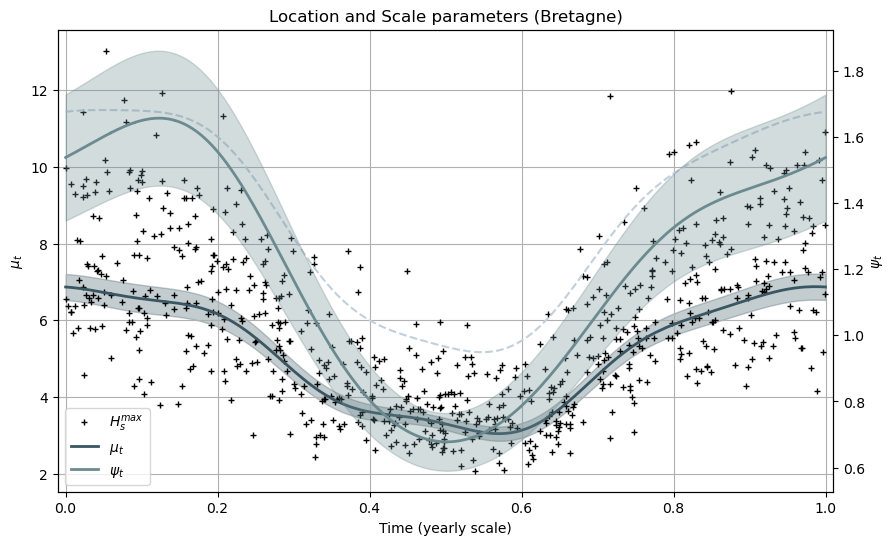

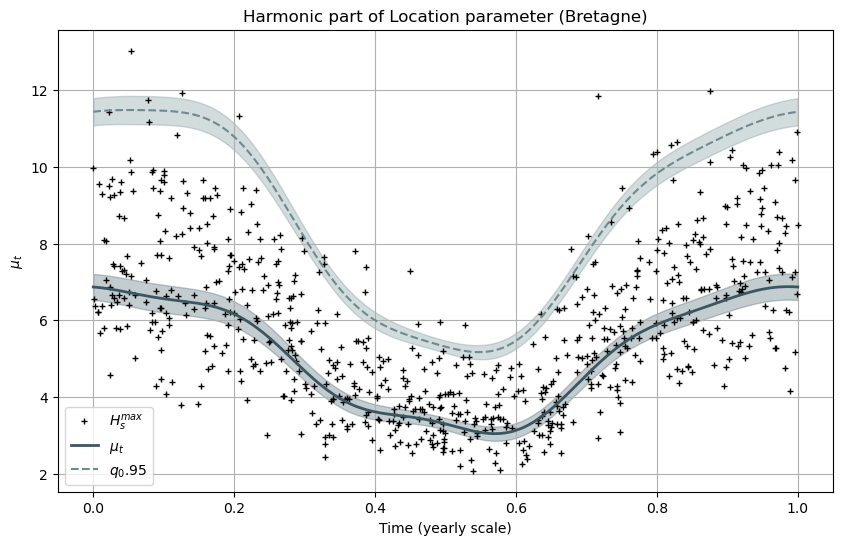

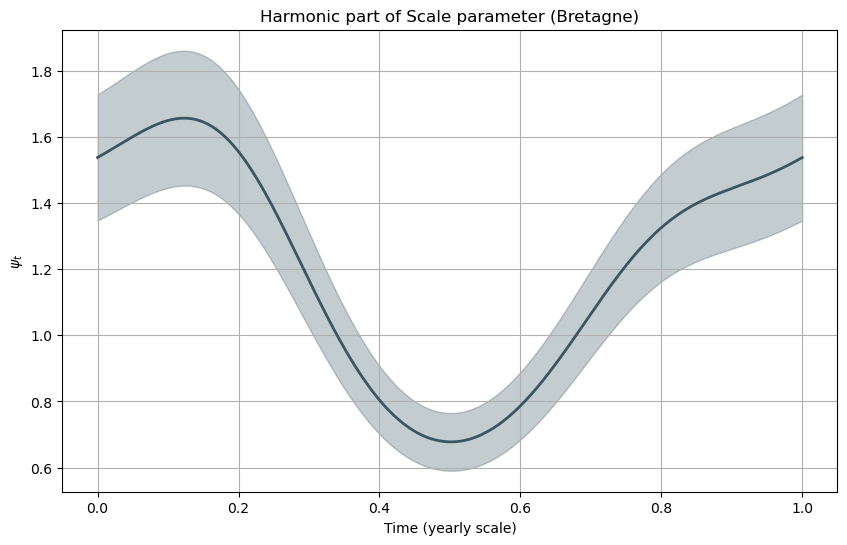

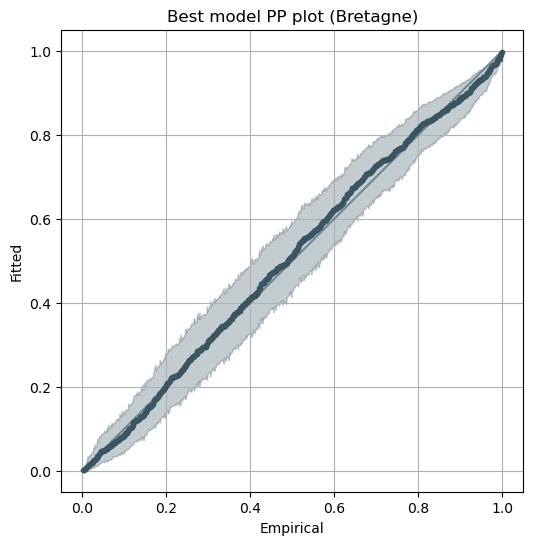

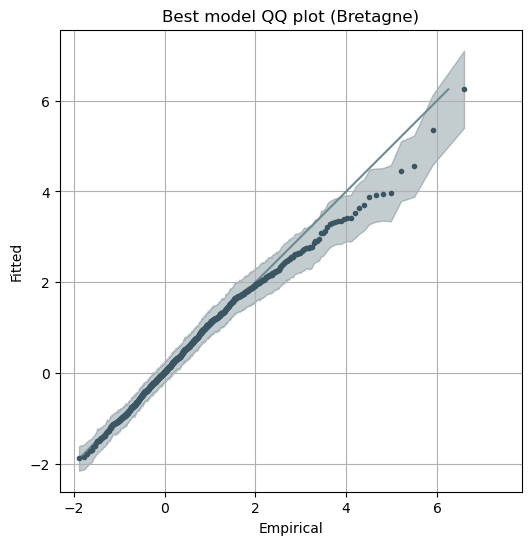

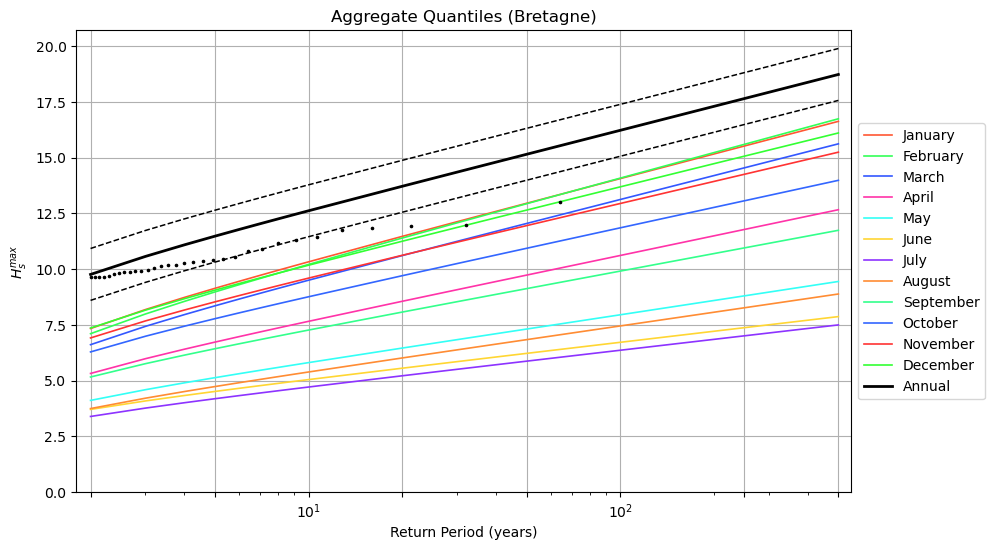

In [ ]:
autogev.plot(annual_plot=False)

### EXAMPLE BRETAGNE

In [11]:
hsmax = np.loadtxt(r"C:\Users\user\Victor\NoEstacionario\MatlabFunctionsMel_Definitivo20110531\HsmaxBretagne.txt")
datemax = np.loadtxt(r"C:\Users\user\Victor\NoEstacionario\MatlabFunctionsMel_Definitivo20110531\DatemaxBretagne.txt")
datemax_annual = datemax % 1
# nfreq = np.loadtxt("N.txt")
kt = np.ones(len(hsmax))

In [12]:
indices = np.loadtxt(r"C:\Users\user\Victor\NoEstacionario\MatlabFunctionsMel_Definitivo20110531\covBretagne.txt")
indices_dict = {i: indices[:, i] for i in range(indices.shape[1])}

In [13]:
autogev = GEVnonstat(xt = hsmax, t = datemax, kt = kt, covariates=indices_dict, trends=True, ejemplo="Bretagne")
beta0,beta,alpha0,alpha,gamma0,gamma,betaT,auxvarphi_loc,list_loc,betaT2,auxvarphi_sc,list_sc,loglikeobj,grad,hessian,popt,stdpara = autogev.AutoAdjust()

Starting the Harmonic iterative process


C:\Users\user\AppData\Local\Temp\ipykernel_15292\3331296994.py:1005: RuntimeWarning: divide by zero encountered in divide
  Depst = zn * (xn*(self.kt-(1+epst)/zn)+z*(-self.kt+1/zn)*np.log(z)/epst) / (epst*z)
C:\Users\user\AppData\Local\Temp\ipykernel_15292\3331296994.py:1005: RuntimeWarning: overflow encountered in divide
  Depst = zn * (xn*(self.kt-(1+epst)/zn)+z*(-self.kt+1/zn)*np.log(z)/epst) / (epst*z)
C:\Users\user\AppData\Local\Temp\ipykernel_15292\3331296994.py:1005: RuntimeWarning: invalid value encountered in add
  Depst = zn * (xn*(self.kt-(1+epst)/zn)+z*(-self.kt+1/zn)*np.log(z)/epst) / (epst*z)


End of the Harmonic iterative process
Harmonic AIC: 2177.488570291188 

Starting the Covariates iterative process
End of the Covariates iterative process
Covariates AIC: 1957.0230624758274 

Starting trends process
Adding trend term to location parameter
Location trend AIC:  1947.1523442945017
Adding trend term to scale parameter
Scale trend AIC:  1941.6971143828728


C:\Users\user\AppData\Local\Temp\ipykernel_15292\3331296994.py:911: RuntimeWarning: overflow encountered in exp
  np.sum(-np.log(self.kt[posG]) + np.log(psit[posG]) + xn[posG] + self.kt[posG]*np.exp(-xn[posG]))


In [17]:
print("beta0",beta0)
print("beta",beta)
print("alpha0",alpha0)
print("alpha",alpha)
print("gamma0",gamma0)
print("gamma",gamma)
print("betaT",betaT)
print("varphi",auxvarphi_loc)
print("betaT2",betaT2)
print("varphi2",auxvarphi_sc)

beta0 5.708464515063562
beta [2.39529458 0.34838651]
alpha0 0.40186305920338233
alpha None
gamma0 None
gamma None
betaT 0.01126297960410581
varphi [ 0.69777126 -0.5947204  -0.15605219 -0.17195793 -0.13349998]
betaT2 -0.00827509554634772
varphi2 [-0.03140864  0.12416869 -0.03872767 -0.10534326  0.04785372]


In [19]:
autogev.list_sc

array([0, 1, 2, 5, 6])

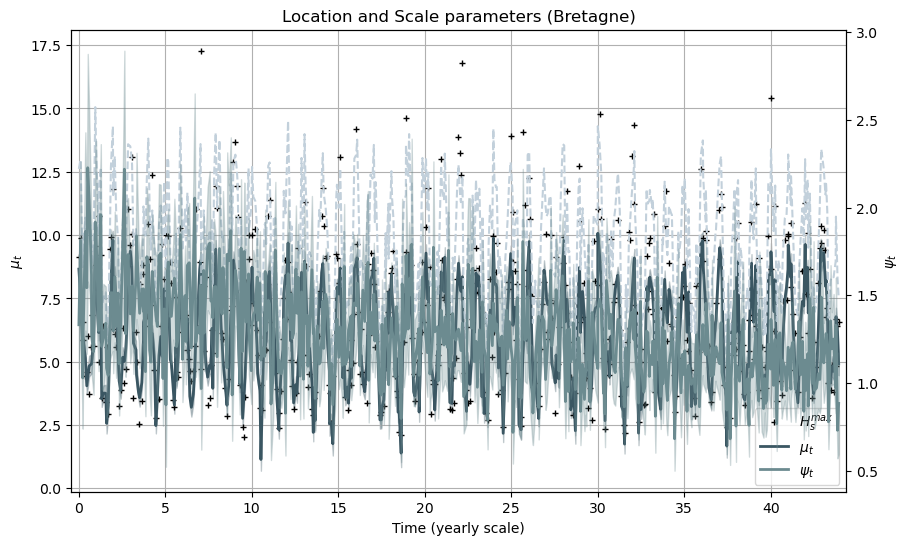

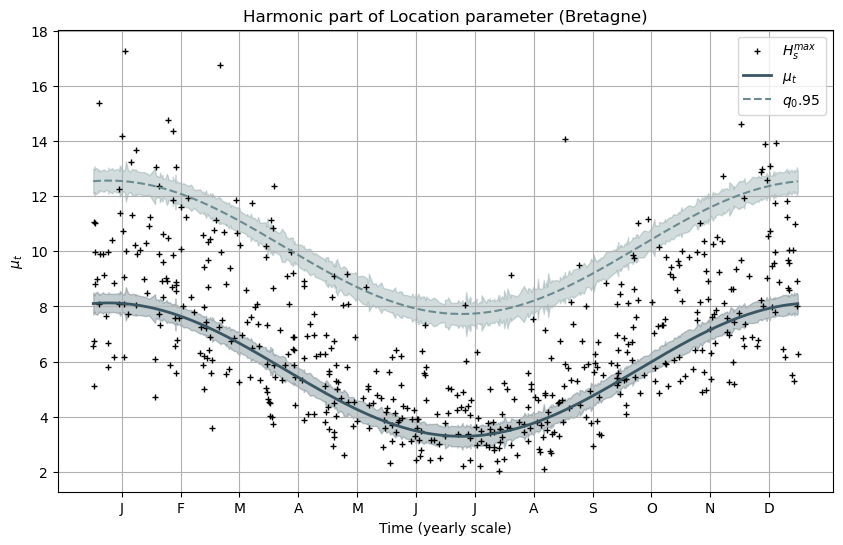

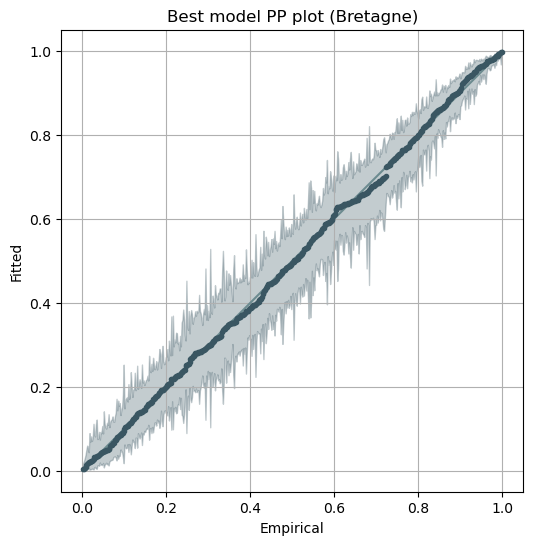

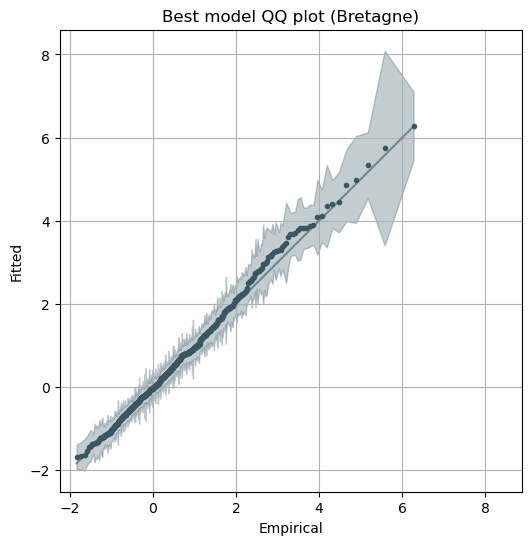

In [16]:
autogev.plot()